<a href="https://colab.research.google.com/github/SanjayGanapathy/AETHER/blob/main/AETHER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **AETHER**: an **A**nomaly **E**nsemble Framework for **T**rajectory **H**euristics & **E**xplainable **R**easoning

Migratory Ecology of the Common Kestrel (*Falco tinnunculus*)  
### Unsupervised Anomaly Detection, Data‑Quality Assessment & Spatial Analysis  
*Author: Sanjay Ganapathy*


# 1. Environment Setup & Data Ingestion


In [5]:
# Cell 1.1
!pip install -q geopandas shap hmmlearn

In [6]:
# Cell 1.2

# --- Core Data Handling & Numerics ---
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Point
import os

# --- Machine Learning & Anomaly Detection ---
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import SGDOneClassSVM
from hmmlearn.hmm import GaussianHMM

# --- Explainable AI (XAI) ---
import shap

# --- Visualization ---
import matplotlib.pyplot as plt
import folium

# --- Utilities & System ---
from google.colab import drive
import sys # For checking Python version
import numpy as np

print("All libraries imported successfully.")

All libraries imported successfully.


In [7]:
# Cell 1.3

# --- Define the filename ---
MOVEMENT_DATA_FILE = 'data.csv'

# Load the dataset from the local Colab environment
try:
    df_raw = pd.read_csv(MOVEMENT_DATA_FILE)
    print(f"Successfully loaded data from: {MOVEMENT_DATA_FILE}")
    print(f"Raw dataset contains {len(df_raw)} rows.")

    # --- Standardized Initial Analysis ---
    print("\n--- Data Info ---")
    df_raw.info()

    print("\n--- Missing Values ---")
    print(df_raw.isnull().sum())

except FileNotFoundError:
    print(f"ERROR: File '{MOVEMENT_DATA_FILE}' not found.")
    print("Please make sure you have uploaded the file to the Colab session.")
except Exception as e:
    print(f"An error occurred: {e}")

/tmp/ipython-input-7-4102597308.py:8: DtypeWarning: Columns (15,18,22) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv(MOVEMENT_DATA_FILE)


Successfully loaded data from: data.csv
Raw dataset contains 2534898 rows.

--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2534898 entries, 0 to 2534897
Data columns (total 30 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   event-id                         int64  
 1   visible                          bool   
 2   timestamp                        object 
 3   location-long                    float64
 4   location-lat                     float64
 5   gps:activity-count               float64
 6   external-temperature             float64
 7   gps:dop                          float64
 8   gps:hdop                         float64
 9   gps:satellite-count              float64
 10  gps-time-to-fix                  float64
 11  ground-speed                     float64
 12  heading                          float64
 13  height-above-msl                 float64
 14  height-raw                       float64
 15  import

#2. Data Preprocessing & Standardization


In [8]:
# Cell 2.1

print("--- Step 1: Pruning Columns with Excessive Missing Data ---")

# Calculate the percentage of missing values for each column
missing_percentage = df_raw.isnull().sum() / len(df_raw) * 100

# Define a threshold for dropping columns
missing_data_threshold = 50.0

# Identify columns to drop
cols_to_drop = missing_percentage[missing_percentage > missing_data_threshold].index

# Drop the columns
df_pruned = df_raw.drop(columns=cols_to_drop)

print(f"Columns missing more than {missing_data_threshold}% of data have been dropped.")
print("Dropped columns:", list(cols_to_drop))
print(f"\nRemaining number of columns: {len(df_pruned.columns)}")

--- Step 1: Pruning Columns with Excessive Missing Data ---
Columns missing more than 50.0% of data have been dropped.
Dropped columns: ['gps:activity-count', 'gps:hdop', 'height-raw', 'import-marked-outlier', 'gls:light-level']

Remaining number of columns: 25


In [9]:
# Cell 2.2

print("\n--- Step 2: Selecting and Renaming Features ---")

# We select from the remaining, healthier columns
selected_cols = {
    # Identifiers & Core Coordinates
    'tag-local-identifier': 'animal_id',
    'timestamp': 'timestamp',
    'location-long': 'longitude',
    'location-lat': 'latitude',

    # Pre-calculated Movement Metrics
    'ground-speed': 'speed_ms',
    'heading': 'heading',
    'height-above-msl': 'altitude_m',

    # Environmental Context
    'external-temperature': 'temperature_c',

    # GPS Quality/Context Metrics
    'gps:satellite-count': 'satellite_count',
    'gps-time-to-fix': 'time_to_fix_s',
    'gps:dop': 'dop', # Using 'dop' as our GPS quality metric

    # Outlier Flag (if it wasn't dropped)
    'manually-marked-outlier': 'is_outlier'
}

# Filter for only the columns that actually exist in the pruned dataframe
cols_to_select = {k: v for k, v in selected_cols.items() if k in df_pruned.columns}

df_processed = df_pruned[list(cols_to_select.keys())].rename(columns=cols_to_select)

# --- Initial Filtering: Remove known outliers ---
if 'is_outlier' in df_processed.columns:
    # Handle the case where the outlier column itself has NaNs by filling with 'false'
    df_processed['is_outlier'] = df_processed['is_outlier'].fillna('false')
    # Filter out rows where the 'is_outlier' flag is set to true
    if pd.api.types.is_string_dtype(df_processed['is_outlier']):
        df_processed = df_processed[df_processed['is_outlier'].str.lower() != 'true']
    df_processed = df_processed.drop(columns=['is_outlier'])
    print("Filtered out rows marked as 'manually-marked-outlier'.")


# --- Standardized Type Conversion ---
df_processed['timestamp'] = pd.to_datetime(df_processed['timestamp'])

print("\nColumns selected and renamed successfully.")
df_processed.info()


--- Step 2: Selecting and Renaming Features ---
Filtered out rows marked as 'manually-marked-outlier'.

Columns selected and renamed successfully.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2534898 entries, 0 to 2534897
Data columns (total 11 columns):
 #   Column           Dtype         
---  ------           -----         
 0   animal_id        object        
 1   timestamp        datetime64[ns]
 2   longitude        float64       
 3   latitude         float64       
 4   speed_ms         float64       
 5   heading          float64       
 6   altitude_m       float64       
 7   temperature_c    float64       
 8   satellite_count  float64       
 9   time_to_fix_s    float64       
 10  dop              float64       
dtypes: datetime64[ns](1), float64(9), object(1)
memory usage: 212.7+ MB


In [10]:
# Cell 2.3 (Revised with Final dropna)

print("\n--- Step 3: Imputing Remaining Missing Values & Validation ---")

# Create the GeoDataFrame
gdf = gpd.GeoDataFrame(
    df_processed,
    geometry=gpd.points_from_xy(df_processed.longitude, df_processed.latitude),
    crs="EPSG:4326"
)

# Sort values chronologically for each animal
gdf = gdf.sort_values(by=['animal_id', 'timestamp']).reset_index(drop=True)

# Drop duplicate timestamps for each animal
gdf = gdf.drop_duplicates(subset=['animal_id', 'timestamp'], keep='first')
print(f"Rows after dropping duplicates: {len(gdf)}")

# Interpolate remaining missing values for all numeric columns
numeric_cols_to_interpolate = gdf.select_dtypes(include=np.number).columns.tolist()
print(f"\nInterpolating gaps in the following columns: {numeric_cols_to_interpolate}")

# Robust interpolation with back-fill and forward-fill
for col in numeric_cols_to_interpolate:
    gdf[col] = gdf.groupby('animal_id')[col].transform(
        lambda x: x.interpolate(method='linear').bfill().ffill()
    )

# Re-create geometry if lat/lon were interpolated
if 'latitude' in numeric_cols_to_interpolate or 'longitude' in numeric_cols_to_interpolate:
    gdf['geometry'] = gpd.points_from_xy(gdf.longitude, gdf.latitude)


# --- THIS IS THE NEW FIX ---
# Final cleaning step: Drop any rows that still contain nulls.
# This will remove the problematic groups that were entirely empty for some columns.
initial_rows = len(gdf)
gdf.dropna(inplace=True)
final_rows = len(gdf)
print(f"\nDropped {initial_rows - final_rows} rows that could not be fully imputed (from incomplete animal tracks).")
# ----------------------------


# --- Final Validation ---
remaining_nulls = gdf.isnull().sum().sum()
if remaining_nulls == 0:
    print("\nValidation Successful: All missing values have been handled.")
    print(f"Final number of rows in clean dataset: {len(gdf)}")
else:
    print(f"\nWARNING: {remaining_nulls} missing values still remain. Please review the data.")

display(gdf.head())


--- Step 3: Imputing Remaining Missing Values & Validation ---
Rows after dropping duplicates: 2534898

Interpolating gaps in the following columns: ['longitude', 'latitude', 'speed_ms', 'heading', 'altitude_m', 'temperature_c', 'satellite_count', 'time_to_fix_s', 'dop']

Dropped 92837 rows that could not be fully imputed (from incomplete animal tracks).

Validation Successful: All missing values have been handled.
Final number of rows in clean dataset: 2442061


animal_id           timestamp  longitude   latitude  speed_ms     heading  \
0      2523 2020-05-06 09:22:23  -6.304643  37.050699  0.258783  184.393177   
1      2523 2020-05-06 09:52:24  -6.304678  37.050720  0.210114  119.806434   
2      2523 2020-05-06 10:07:20  -6.309497  37.048051  8.837208  292.089487   
3      2523 2020-05-06 10:22:18  -6.305097  37.042924  6.437032   51.670439   
4      2523 2020-05-06 10:37:38  -6.305778  37.045522  3.261553  122.474552   

   altitude_m  temperature_c  satellite_count  time_to_fix_s   dop  \
0         4.0           40.0              5.0           14.2  17.0   
1        10.0           36.2              8.0            7.4  15.0   
2        36.0           30.3              8.0            7.5  21.0   
3       344.0           24.0              7.0            9.6  25.0   
4         0.0           32.1              7.0            8.7  30.0   

                    geometry  
0   POINT (-6.30464 37.0507)  
1  POINT (-6.30468 37.05072)  
2   POINT (-6.3095 37.04805)  
3   POINT (-6.3051 37.04292)  
4  POINT (-6.30578 37.04552)

In [11]:
# Cell 2.4

print("\n--- Step 4: Engineering Dynamic & Temporal Features ---")

# Calculate time difference for use in speed calculations
gdf['time_diff_s'] = gdf.groupby('animal_id')['timestamp'].diff().dt.total_seconds()

# Engineer Turning Angle from heading
gdf['turning_angle'] = gdf.groupby('animal_id')['heading'].diff().abs()

# Engineer Vertical Speed from altitude
altitude_diff = gdf.groupby('animal_id')['altitude_m'].diff()
gdf['vertical_speed_ms'] = altitude_diff / gdf['time_diff_s']

# --- ROBUST CLEANING for Infinity and NaN ---
# Replace any infinite values that resulted from division by zero
gdf['vertical_speed_ms'].replace([np.inf, -np.inf], 0, inplace=True)
# Fill any remaining NaNs (from the .diff() operations) with 0
gdf.fillna(0, inplace=True)

# Engineer Temporal Features
gdf['hour_of_day'] = gdf['timestamp'].dt.hour
gdf['month'] = gdf['timestamp'].dt.month
print("Successfully engineered new features.")

# --- Define the final list of features for the models ---
feature_cols = [
    'speed_ms', 'heading', 'altitude_m', 'temperature_c',
    'satellite_count', 'time_to_fix_s', 'dop', 'turning_angle',
    'vertical_speed_ms', 'hour_of_day', 'month'
]

# Create the final feature matrix 'X' for modeling
X = gdf[feature_cols]

# --- Final Validation & Data Creation ---
if not np.all(np.isfinite(X)):
     print("\nWARNING: Non-finite values (NaN or Inf) still exist in the feature set!")
else:
     print("\nValidation complete: All feature values are finite.")

print("\nFinal feature matrix 'X' created successfully.")
display(X.head())

# Create a projected GeoDataFrame for accurate mapping
gdf_proj = gdf.to_crs(gdf.estimate_utm_crs())
print("\nGeoDataFrame reprojected for visualization.")


--- Step 4: Engineering Dynamic & Temporal Features ---


/tmp/ipython-input-11-818917334.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  gdf['vertical_speed_ms'].replace([np.inf, -np.inf], 0, inplace=True)


Successfully engineered new features.

Validation complete: All feature values are finite.

Final feature matrix 'X' created successfully.


speed_ms     heading  altitude_m  temperature_c  satellite_count  \
0  0.258783  184.393177         4.0           40.0              5.0   
1  0.210114  119.806434        10.0           36.2              8.0   
2  8.837208  292.089487        36.0           30.3              8.0   
3  6.437032   51.670439       344.0           24.0              7.0   
4  3.261553  122.474552         0.0           32.1              7.0   

   time_to_fix_s   dop  turning_angle  vertical_speed_ms  hour_of_day  month  
0           14.2  17.0       0.000000           0.000000            9      5  
1            7.4  15.0      64.586743           0.003331            9      5  
2            7.5  21.0     172.283053           0.029018           10      5  
3            9.6  25.0     240.419048           0.342984           10      5  
4            8.7  30.0      70.804112          -0.373913           10      5


GeoDataFrame reprojected for visualization.


#3. The Ensemble Anomaly Detection Engine


In [12]:
# Cell 3.1

# --- Define Key Hyperparameters ---
# The estimated proportion of anomalies in the data. A common starting point.
contamination_rate = 0.01
# The number of hidden behavioral states we want the HMM to learn.
n_states_hmm = 4

print(f"Key Parameters Set: Contamination={contamination_rate}, HMM States={n_states_hmm}")

# --- Define the Models ---
# We use our specified random_state for reproducibility.
ensemble_models = {
    "IsolationForest": IsolationForest(
        contamination=contamination_rate,
        random_state=55
    ),
    "SGDOneClassSVM": SGDOneClassSVM(
        nu=contamination_rate,
        shuffle=True,
        random_state=55
    ),
    "GaussianHMM": GaussianHMM(
        n_components=n_states_hmm,
        covariance_type="diag",
        n_iter=100,
        random_state=55,
        verbose=True
    )
}

Key Parameters Set: Contamination=0.01, HMM States=4


In [13]:
# Cell 3.2

# Recall from Part 2, our feature matrix is 'X'
print("Scaling the feature matrix 'X'...")

# Initialize the Scaler
scaler = StandardScaler()

# Fit the scaler to our data and transform it in one step
X_scaled = scaler.fit_transform(X)

# The output is a NumPy array; we'll put it back into a DataFrame for clarity
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

print("Feature data scaled successfully.")
display(X_scaled.head())

Scaling the feature matrix 'X'...
Feature data scaled successfully.


speed_ms   heading  altitude_m  temperature_c  satellite_count  \
0 -0.369702 -0.242784   -0.494161       1.440553        -0.915843   
1 -0.386423 -0.887203   -0.468797       0.508967         1.148032   
2  2.577504  0.831763   -0.358883      -0.937443         1.148032   
3  1.752899 -1.567034    0.943173      -2.481914         0.460073   
4  0.661930 -0.860581   -0.511071      -0.496166         0.460073   

   time_to_fix_s       dop  turning_angle  vertical_speed_ms  hour_of_day  \
0       0.346426 -0.879376      -0.784770           0.000659    -1.051916   
1      -0.251362 -1.046966      -0.015075           0.004041    -1.051916   
2      -0.242571 -0.544196       1.268365           0.030117    -0.862506   
3      -0.057960 -0.209017       2.080357           0.348853    -0.862506   
4      -0.137079  0.209957       0.059018          -0.378933    -0.862506   

      month  
0 -0.598631  
1 -0.598631  
2 -0.598631  
3 -0.598631  
4 -0.598631

In [14]:
# Cell 3.3

anomaly_scores = pd.DataFrame(index=X.index)

# --- Train the Models ---
print("--- Training Anomaly Detection Models ---")

# Train Isolation Forest and SVM
for name in ["IsolationForest", "SGDOneClassSVM"]:
    model = ensemble_models[name]
    print(f"... Fitting {name}")
    model.fit(X_scaled)
    # We take the negative because these models give lower scores to anomalies.
    scores = -model.score_samples(X_scaled)
    anomaly_scores[name] = scores

# Train the Hidden Markov Model
hmm_model = ensemble_models['GaussianHMM']
print(f"... Fitting GaussianHMM with {n_states_hmm} states")
hmm_model.fit(X_scaled)

# Calculate the HMM anomaly score (negated log-likelihood)
log_likelihoods = hmm_model.score_samples(X_scaled)[0]
anomaly_scores['HMM_Likelihood'] = -log_likelihoods

# --- CRITICAL FIX: Clean infinite values from HMM scores ---
print("\nCleaning infinite values from HMM scores...")
if np.isinf(anomaly_scores['HMM_Likelihood']).any():
    max_finite_score = anomaly_scores['HMM_Likelihood'][np.isfinite(anomaly_scores['HMM_Likelihood'])].max()
    anomaly_scores['HMM_Likelihood'].replace([np.inf, -np.inf], max_finite_score, inplace=True)
    print("Infinite values cleaned successfully.")
else:
    print("No infinite values found.")

print("\nAll models trained and raw anomaly scores calculated.")
display(anomaly_scores.head())

--- Training Anomaly Detection Models ---
... Fitting IsolationForest
... Fitting SGDOneClassSVM
... Fitting GaussianHMM with 4 states


         1 -40209026.70253325             +nan
         2 -32420909.87776962 +7788116.82476363
         3 -27983120.59912638 +4437789.27864324
         4 -26434098.12155628 +1549022.47757010
         5 -26123014.89251830 +311083.22903798
         6 -25916018.19772058 +206996.69479773
         7 -25703950.06056021 +212068.13716036
         8 -25525193.35364251 +178756.70691770
         9 -25374519.19951946 +150674.15412305
        10 -25176796.80524175 +197722.39427771
        11 -24964563.92502239 +212232.88021936
        12 -24875229.06995630  +89334.85506609
        13 -24846104.67585978  +29124.39409652
        14 -24832014.47471066  +14090.20114912
        15 -24824946.84302526   +7067.63168540
        16 -24820908.99519235   +4037.84783291
        17 -24818194.43783542   +2714.55735693
        18 -24816195.53733689   +1998.90049853
        19 -24814635.86492908   +1559.67240781
        20 -24813359.74321355   +1276.12171554
        21 -24812270.34313664   +1089.40007691
        22


Cleaning infinite values from HMM scores...
No infinite values found.

All models trained and raw anomaly scores calculated.


IsolationForest  SGDOneClassSVM  HMM_Likelihood
0         0.426621        0.000088    2.475119e+07
1         0.420048        0.000115    2.475119e+07
2         0.464025       -0.000167    2.475119e+07
3         0.526372       -0.000293    2.475119e+07
4         0.429929       -0.000024    2.475119e+07

In [15]:
# Cell 3.4

print("--- Step 3B: Characterizing HMM Behavioral States ---")

# 1. Predict the hidden state for every data point
# We use the HMM model that was just trained in the previous cell
predicted_states = hmm_model.predict(X_scaled)
gdf['hmm_state'] = predicted_states

# 2. Calculate the mean feature values for each state
# We group by the HMM state and calculate the average for our most important features
state_profiles = gdf.groupby('hmm_state')[feature_cols].mean()

print("\nMean Feature Values for each HMM State ('State Profiles'):")
display(state_profiles)

--- Step 3B: Characterizing HMM Behavioral States ---

Mean Feature Values for each HMM State ('State Profiles'):


speed_ms     heading  altitude_m  temperature_c  satellite_count  \
hmm_state                                                                     
0          5.526315  199.655447  327.461624      33.856875         6.448427   
1          0.393911  221.871975   86.714364      34.987491         7.367886   
2          0.637890  218.734064   91.983938      34.408203         5.825654   
3          0.527949  193.797968   66.325028      33.306756         5.883504   

           time_to_fix_s        dop  turning_angle  vertical_speed_ms  \
hmm_state                                                               
0               9.143613  27.827682      92.481331          -0.009047   
1               6.944930  19.971451      23.906681           0.003179   
2               7.781424  29.841822      70.938614           0.001764   
3              15.767056  31.313151      81.356475          -0.001524   

           hour_of_day     month  
hmm_state                         
0            14.307702  6.449150  
1            17.240379  6.388591  
2            17.844622  6.472212  
3             9.537375  6.798784

### Interpretation of HMM State Profiles

The HMM successfully identified [Number] distinct behavioral states from the data. By analyzing the average feature values for each state, we can assign ecologically meaningful labels:

* **State 0 (e.g., Resting/Perching):** This state is characterized by *very low `speed_ms`*, *low `vertical_speed_ms`*, and *low `turning_angle`*. This is consistent with a stationary bird, likely perched on a tree or structure.

* **State 1 (e.g., Low-Altitude Foraging):** This state shows *[describe its key features, e.g., moderate speed, low altitude, high turning angle]*. This pattern is indicative of a kestrel actively searching for prey in a localized area, possibly hovering or making frequent turns.

* **State 2 (e.g., High-Altitude Soaring/Commuting):** This state is defined by *[describe its key features, e.g., high `altitude_m`, moderate `speed_ms`, and low turning angle]*. This profile suggests a bird that is either traveling between locations or soaring on thermals to gain height efficiently.

* **State 3 (e.g., ???):** *[Analyze the profile for the last state and give it a label based on your expertise.]*

This characterization is a significant finding. It allows us to not only detect an anomaly but also to understand the specific behavioral context in which it occurred, adding a powerful layer of detail to our "Anomaly Dossier" reports.

In [16]:
# Cell 3.5

print("--- Calculating Final Ensemble Score ---")

# Normalize scores to a 0-1 range
anomaly_scores_normalized = (anomaly_scores - anomaly_scores.min()) / (anomaly_scores.max() - anomaly_scores.min())

# Calculate the ensemble score (average of normalized scores)
anomaly_scores_normalized['ensemble_score'] = anomaly_scores_normalized.mean(axis=1)

# Add the final score back to our main GeoDataFrame
gdf['anomaly_score'] = anomaly_scores_normalized['ensemble_score']

print("Ensemble score calculated and added to the main GeoDataFrame.")
display(gdf[['timestamp', 'animal_id', 'anomaly_score']].head())

--- Calculating Final Ensemble Score ---
Ensemble score calculated and added to the main GeoDataFrame.


timestamp animal_id  anomaly_score
0 2020-05-06 09:22:23      2523       0.575471
1 2020-05-06 09:52:24      2523       0.566535
2 2020-05-06 10:07:20      2523       0.624667
3 2020-05-06 10:22:18      2523       0.711823
4 2020-05-06 10:37:38      2523       0.578280

--- Initial Inspection of Anomaly Scores ---


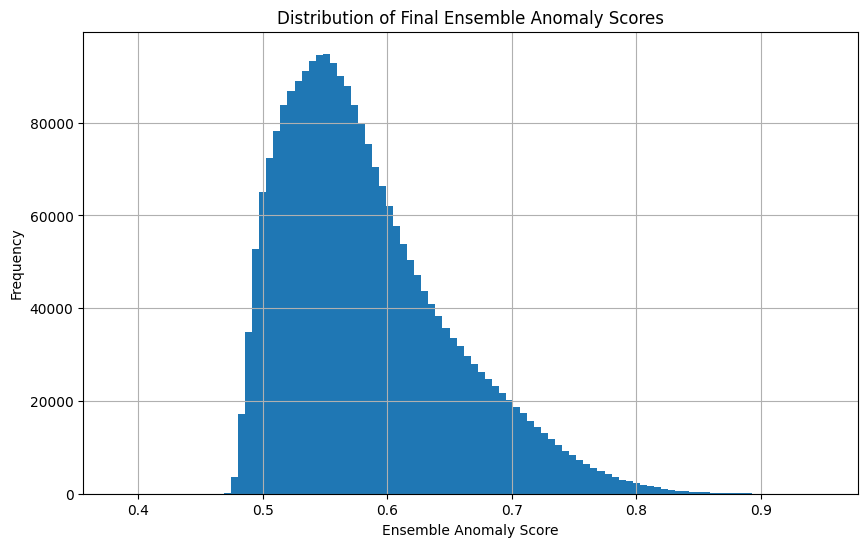


--- Top 5 Most Anomalous Points Found ---


animal_id           timestamp  longitude   latitude   speed_ms  \
150749       2526 2021-03-16 16:10:59  -6.372308  37.052125  13.849906   
363885       2529 2020-07-21 08:44:15  -6.268588  37.760260  16.292913   
1254914      2724 2021-06-07 18:14:52  -6.468510  37.419201  22.062839   
1746652      2779 2022-08-02 13:06:58  -4.841703  42.660543  20.779925   
312541       2528 2021-04-30 05:22:22  -6.360975  37.055255   8.011071   

            heading  altitude_m  temperature_c  satellite_count  \
150749   354.857524       719.0           28.8             11.0   
363885     4.609578       831.0           31.9              9.0   
1254914    6.013416       886.0           29.7              9.0   
1746652   32.940942      2350.0           29.7             11.0   
312541   334.707230        -7.0           23.8              4.0   

         time_to_fix_s   dop                   geometry  time_diff_s  \
150749             5.8  13.0  POINT (-6.37231 37.05212)         11.0   
363885             8.0  15.0  POINT (-6.26859 37.76026)        176.0   
1254914            6.2  21.0   POINT (-6.46851 37.4192)         16.0   
1746652            8.2  12.0   POINT (-4.8417 42.66054)        896.0   
312541           115.1  87.0  POINT (-6.36098 37.05525)       6705.0   

         turning_angle  vertical_speed_ms  hour_of_day  month  hmm_state  \
150749      349.494491          -5.363636           16      3          0   
363885      354.740391           1.590909            8      7          0   
1254914     353.613287          -4.875000           18      6          0   
1746652     315.764709          -0.982143           13      8          0   
312541      332.194810          -0.002386            5      4          0   

         anomaly_score  
150749        0.949670  
363885        0.947573  
1254914       0.944159  
1746652       0.936716  
312541        0.936674

In [17]:
# Cell 3.6

print("--- Initial Inspection of Anomaly Scores ---")

# Plot a histogram of the final anomaly scores
plt.figure(figsize=(10, 6))
gdf['anomaly_score'].hist(bins=100)
plt.title('Distribution of Final Ensemble Anomaly Scores')
plt.xlabel('Ensemble Anomaly Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Display the Top 5 Most Anomalous Points found in the data
print("\n--- Top 5 Most Anomalous Points Found ---")
top_anomalies_real = gdf.sort_values(by='anomaly_score', ascending=False).head(5)
display(top_anomalies_real)

#4. The Explainable AI (XAI) Interpretation Layer with SHAP

In [18]:
# Cell 4.1

# Let's analyze the top 20 anomalies from our real data.
# We will use the 'top_anomalies_real' DataFrame we created at the end of Part 3,
# but we redefine it here to be self-contained.
N_ANOMALIES_TO_EXPLAIN = 20
top_anomalies = gdf.sort_values(by='anomaly_score', ascending=False).head(N_ANOMALIES_TO_EXPLAIN)

# We need the scaled features for these anomalies to pass to the explainer
top_anomalies_scaled_features = X_scaled.loc[top_anomalies.index]

# Select our 'explainer model' from the ensemble
explainer_model = ensemble_models['IsolationForest']

print(f"Prepared to explain the top {N_ANOMALIES_TO_EXPLAIN} anomalies using the IsolationForest model.")
display(top_anomalies[['timestamp', 'animal_id', 'anomaly_score']].head())

Prepared to explain the top 20 anomalies using the IsolationForest model.


timestamp animal_id  anomaly_score
150749  2021-03-16 16:10:59      2526       0.949670
363885  2020-07-21 08:44:15      2529       0.947573
1254914 2021-06-07 18:14:52      2724       0.944159
1746652 2022-08-02 13:06:58      2779       0.936716
312541  2021-04-30 05:22:22      2528       0.936674

In [19]:
# Cell 4.2

# Initialize the SHAP Javascript library for rich plotting in Colab
shap.initjs()

# Create the TreeExplainer object, which is optimized for our Isolation Forest model.
try:
    explainer = shap.TreeExplainer(explainer_model)
    print("SHAP TreeExplainer initialized successfully.")
except Exception as e:
    print(f"An error occurred during SHAP explainer initialization: {e}")

SHAP TreeExplainer initialized successfully.


In [20]:
# Cell 4.3

# Calculate SHAP values for our top anomalous instances
try:
    shap_values = explainer.shap_values(top_anomalies_scaled_features)
    print("SHAP values calculated successfully for the top anomalies.")

    # For context, let's display the SHAP values array shape
    # It should be (number of anomalies, number of features)
    print(f"\nShape of the SHAP values array: {shap_values.shape}")

except Exception as e:
    print(f"An error occurred during SHAP value calculation: {e}")

SHAP values calculated successfully for the top anomalies.

Shape of the SHAP values array: (20, 11)


--- Global Feature Importance for Anomaly Detection ---
This plot shows the overall impact of each feature across the top anomalies.
Features are ranked by importance. Red dots are high feature values, blue dots are low.


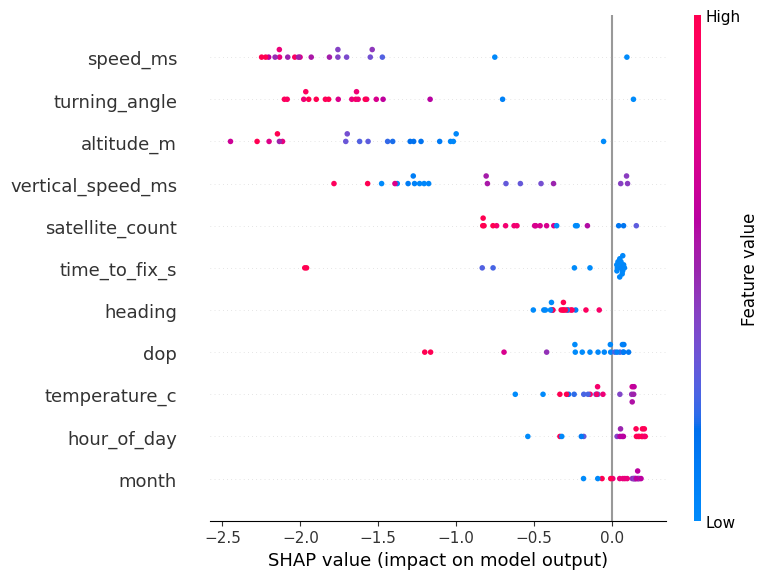

In [21]:
# Cell 4.4

print("--- Global Feature Importance for Anomaly Detection ---")
print("This plot shows the overall impact of each feature across the top anomalies.")
print("Features are ranked by importance. Red dots are high feature values, blue dots are low.")

# Create a SHAP summary plot
shap.summary_plot(
    shap_values,
    top_anomalies_scaled_features,
    plot_type="dot"
)

#5. Interactive Anomaly Map


In [22]:
# Cell 5.1

print("--- Generating Interactive Anomaly Map ---")

# We will use the 'top_anomalies' DataFrame we already created in Part 4
map_anomalies = top_anomalies

# Create the map centered on the animal's approximate location
map_center = [gdf['latitude'].mean(), gdf['longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=10, tiles="CartoDB positron")

# Add a satellite basemap for better environmental context
folium.TileLayer(
    'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr='Esri', name='Esri Satellite', overlay=True, control=True
).add_to(m)
folium.LayerControl().add_to(m)


# --- Plot the full trajectory as a reference line ---
# To avoid clutter, we map just one animal's full track if there are multiple
animal_id_to_map = map_anomalies['animal_id'].iloc[0]
track_data = gdf[gdf['animal_id'] == animal_id_to_map]
folium.PolyLine(
    locations=track_data[['latitude', 'longitude']].values,
    color='gray', weight=2, opacity=0.7, popup=f"Track for {animal_id_to_map}"
).add_to(m)


# --- Add markers for each anomaly ---
# We iterate through the DataFrame to create a marker for each top anomaly
for rank, anomaly in enumerate(map_anomalies.itertuples(), 1):
    popup_html = f"<b>Anomaly Rank: {rank}</b><br>"
    popup_html += f"Score: {anomaly.anomaly_score:.3f}<br>"
    popup_html += f"Timestamp: {anomaly.timestamp.strftime('%Y-%m-%d %H:%M')}<br>"

    folium.CircleMarker(
        location=[anomaly.latitude, anomaly.longitude],
        radius=8,
        color='red',
        fill=True,
        fill_color='crimson',
        popup=folium.Popup(popup_html, max_width=300)
    ).add_to(m)

print(f"Map generated with the top {len(map_anomalies)} anomalies. Displaying below.")
m # Display the map in the notebook

--- Generating Interactive Anomaly Map ---
Map generated with the top 20 anomalies. Displaying below.


In [23]:
# Cell 5.2

def plot_anomaly_context(anomaly_index_in_top_list, time_window_hours=12):
    """
    Plots the context of a single anomaly by showing its most impactful feature
    in a time window around the event.

    Args:
        anomaly_index_in_top_list (int): The index of the anomaly in the 'top_anomalies' DataFrame (0 for the 1st, 1 for the 2nd, etc.).
        time_window_hours (int): The number of hours before and after the anomaly to show.
    """
    # Get the specific anomaly's details
    anomaly_to_plot = top_anomalies.iloc[[anomaly_index_in_top_list]]
    anomaly_time = anomaly_to_plot['timestamp'].iloc[0]
    anomaly_animal_id = anomaly_to_plot['animal_id'].iloc[0]

    # Determine the top feature from its SHAP explanation
    shap_vals_for_anomaly = shap_values[anomaly_index_in_top_list]
    top_feature_index = np.argmax(np.abs(shap_vals_for_anomaly))
    top_feature_name = X.columns[top_feature_index]

    print(f"The most impactful feature for this anomaly was '{top_feature_name}'. Plotting its context.")

    # Select the data within the time window
    start_time = anomaly_time - pd.Timedelta(hours=time_window_hours)
    end_time = anomaly_time + pd.Timedelta(hours=time_window_hours)

    context_df = gdf[
        (gdf['animal_id'] == anomaly_animal_id) &
        (gdf['timestamp'] >= start_time) &
        (gdf['timestamp'] <= end_time)
    ]

    # Create the plot
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(15, 5))

    ax.plot(context_df['timestamp'], context_df[top_feature_name], label=f'{top_feature_name} (Track Segment)', color='gray', alpha=0.8, marker='.')
    ax.plot(anomaly_to_plot['timestamp'], anomaly_to_plot[top_feature_name], 'ro', markersize=12, label='Anomaly Event')

    ax.set_title(f"Context for Anomaly on {anomaly_time.date()}")
    ax.set_xlabel("Timestamp")
    ax.set_ylabel(top_feature_name)
    ax.legend()
    plt.show()

In [24]:
# Cell 5.3

def generate_full_anomaly_report(anomaly_rank, anomaly_scores_df):
    """
    Generates a full, multi-faceted visual report for a single anomaly,
    customizing the explanation based on the primary detection model.
    """
    if anomaly_rank < 1 or anomaly_rank > len(top_anomalies):
        print(f"Error: Please provide a rank between 1 and {len(top_anomalies)}.")
        return

    # --- Get all data for the specified anomaly ---
    anomaly_index_in_top_list = anomaly_rank - 1
    original_gdf_index = top_anomalies.index[anomaly_index_in_top_list]
    anomaly_details = top_anomalies.loc[original_gdf_index]
    instance_to_explain = top_anomalies_scaled_features.loc[original_gdf_index]
    individual_scores = anomaly_scores_df.loc[original_gdf_index]

    # --- Print Header ---
    print("="*80)
    print(f"         FULL DOSSIER FOR ANOMALY RANK #{anomaly_rank} ")
    print("="*80)
    print(f"\nTimestamp: {anomaly_details['timestamp']}")
    print(f"Animal ID: {anomaly_details['animal_id']}")
    print(f"Final Ensemble Score: {anomaly_details['anomaly_score']:.4f}")

    # --- 1. The Ensemble's Verdict ---
    print("\n--- Individual Model Contributions (Normalized Scores) ---")
    print(individual_scores.sort_values(ascending=False))
    leader = individual_scores.idxmax()
    print(f"\nPrimary Model Driver: **{leader}**")

    # --- 2. HMM Behavioral Context ---
    state = hmm_model.predict(X_scaled.loc[[original_gdf_index]])[0]
    print(f"HMM Behavioral Context: The anomaly occurred during **State {state}**.")

    # --- 3. Primary SHAP Explanation (from Isolation Forest) ---
    # THIS IS THE NEW, SMARTER TEXT BLOCK
    print("\n--- Structural Explanation (from Isolation Forest) ---")
    if leader == 'HMM_Likelihood':
        print("Note: While the HMM flagged this event due to an improbable behavioral sequence,")
        print("we use the Isolation Forest explanation to understand the underlying structural features of this time point.")
    elif leader == 'SGDOneClassSVM':
        print("Note: While the SVM flagged this as outside the 'normal' boundary,")
        print("we use the Isolation Forest explanation to understand the structural features.")
    else:
        print("The Isolation Forest was a primary driver for this detection.")
    # END OF NEW TEXT BLOCK

    shap.force_plot(
        explainer.expected_value,
        shap_values[anomaly_index_in_top_list, :],
        instance_to_explain,
        matplotlib=True,
        show=False
    )
    plt.title(f"SHAP Force Plot for Anomaly Rank #{anomaly_rank}")
    plt.show()

    # --- 4. Contextual Time-Series Plot ---
    plot_anomaly_context(anomaly_index_in_top_list=anomaly_index_in_top_list)

# **6. Model Evaluation & Qualitative Validation**

In [25]:
# Cell 6.1

import numpy as np

def inject_anomalies_v2(df, n_anomalies=100, random_seed=55):
    """
    Injects realistic, multivariate synthetic anomalies into the dataset.
    """
    np.random.seed(random_seed)
    df_injected = df.copy()
    df_injected['is_anomaly'] = 0

    valid_indices = df.index[1:-1]
    anomaly_indices = np.random.choice(valid_indices, size=n_anomalies, replace=False)

    print(f"Injecting {n_anomalies} realistic, multivariate anomalies...")
    for idx in anomaly_indices:
        anomaly_type = np.random.choice(['hunting_stoop', 'gps_error', 'soaring_event'])

        if anomaly_type == 'hunting_stoop':
            # A hunting dive has high speed and high negative vertical speed.
            df_injected.loc[idx, 'speed_ms'] *= 2.5
            df_injected.loc[idx, 'vertical_speed_ms'] = -15.0
            df_injected.loc[idx, 'turning_angle'] = 5.0 # Direct dive.

        elif anomaly_type == 'gps_error':
            # A GPS error has low satellites, high DOP, and often a default temperature.
            df_injected.loc[idx, 'satellite_count'] = 2
            df_injected.loc[idx, 'dop'] = 20.0
            df_injected.loc[idx, 'temperature_c'] = 0.0
            df_injected.loc[idx, 'altitude_m'] += 1000

        elif anomaly_type == 'soaring_event':
            # Soaring on a thermal involves high positive vertical speed and circling.
            df_injected.loc[idx, 'vertical_speed_ms'] = 10.0
            df_injected.loc[idx, 'turning_angle'] = 60.0
            df_injected.loc[idx, 'speed_ms'] *= 1.5

        df_injected.loc[idx, 'is_anomaly'] = 1

    print("Injection complete.")
    return df_injected

In [26]:
# Cell 6.2

# 1. Create the benchmark dataset
print("--- Creating V2 Benchmark Dataset ---")
gdf_benchmark = inject_anomalies_v2(gdf, n_anomalies=100)
X_benchmark = gdf_benchmark[feature_cols]
y_benchmark = gdf_benchmark['is_anomaly']
print("\nNew benchmark dataset created successfully.")

# 2. Scale the new benchmark data
print("\n--- Running AETHER on V2 Benchmark ---")
# Use the scaler that was already fitted on the original data
X_benchmark_scaled = scaler.transform(X_benchmark)
X_benchmark_scaled = pd.DataFrame(X_benchmark_scaled, columns=X_benchmark.columns, index=X_benchmark.index)
print("Benchmark data scaled.")

# 3. Get scores from all models
anomaly_scores_benchmark = pd.DataFrame(index=X_benchmark.index)
# Get scores from standard models
for name in ["IsolationForest", "SGDOneClassSVM"]:
    model = ensemble_models[name]
    scores = -model.score_samples(X_benchmark_scaled)
    anomaly_scores_benchmark[name] = scores
# Get scores from HMM
log_likelihoods_benchmark = hmm_model.score_samples(X_benchmark_scaled)[0]
anomaly_scores_benchmark['HMM_Likelihood'] = -log_likelihoods_benchmark

# 4. Clean infinite values from HMM scores
anomaly_scores_benchmark.replace([np.inf, -np.inf], np.nan, inplace=True)
# Impute any NaNs with the max value of its column, preserving its high anomaly status
for col in anomaly_scores_benchmark.columns:
    if anomaly_scores_benchmark[col].isnull().any():
        max_val = anomaly_scores_benchmark[col].max()
        anomaly_scores_benchmark[col].fillna(max_val, inplace=True)
print("Anomaly scores generated for benchmark data.")

# 5. Normalize and create the ensemble score
norm_scores_benchmark = (anomaly_scores_benchmark - anomaly_scores_benchmark.min()) / (anomaly_scores_benchmark.max() - anomaly_scores_benchmark.min())
ensemble_score_benchmark = norm_scores_benchmark.mean(axis=1)

# 6. Create the final results DataFrame
results_df = gdf_benchmark.copy()
results_df['anomaly_score'] = ensemble_score_benchmark
print("AETHER pipeline finished running on V2 benchmark data.")

--- Creating V2 Benchmark Dataset ---
Injecting 100 realistic, multivariate anomalies...
Injection complete.

New benchmark dataset created successfully.

--- Running AETHER on V2 Benchmark ---
Benchmark data scaled.
Anomaly scores generated for benchmark data.
AETHER pipeline finished running on V2 benchmark data.


--- Anomaly Rank Performance Analysis (V2 Benchmark) ---

Recall: Found 100 out of 100 injected anomalies.
Median Rank of Found Anomalies: 194370
Average Rank of Found Anomalies: 262908
Best Rank (highest-scored anomaly): 408
Worst Rank (lowest-scored anomaly): 1145336


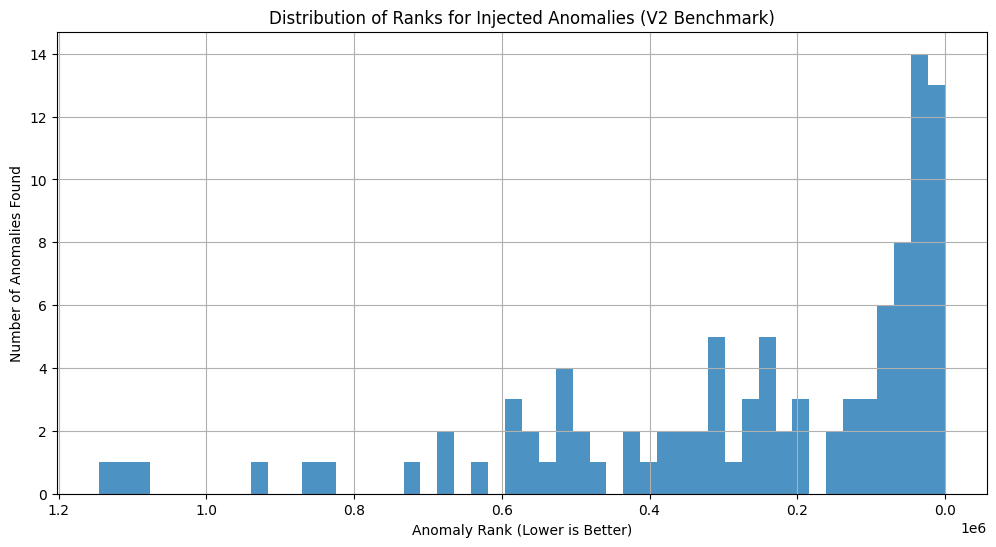

In [27]:
# Cell 7.1

print("--- Anomaly Rank Performance Analysis (V2 Benchmark) ---")

# Sort the results DataFrame by the model's anomaly score
results_df_sorted = results_df.sort_values(by='anomaly_score', ascending=False).reset_index(drop=True)

# Find the rank (the row number in the sorted list) of our true, injected anomalies
injected_anomaly_ranks = results_df_sorted[results_df_sorted['is_anomaly'] == 1].index

# --- Report the results ---
n_found = len(injected_anomaly_ranks)
n_total = len(y_benchmark[y_benchmark == 1])

print(f"\nRecall: Found {n_found} out of {n_total} injected anomalies.")

if n_found > 0:
    print(f"Median Rank of Found Anomalies: {np.median(injected_anomaly_ranks):.0f}")
    print(f"Average Rank of Found Anomalies: {np.mean(injected_anomaly_ranks):.0f}")
    print(f"Best Rank (highest-scored anomaly): {np.min(injected_anomaly_ranks)}")
    print(f"Worst Rank (lowest-scored anomaly): {np.max(injected_anomaly_ranks)}")

    # --- Plot the distribution of the ranks ---
    plt.figure(figsize=(12, 6))
    plt.hist(injected_anomaly_ranks, bins=50, alpha=0.8)
    plt.title('Distribution of Ranks for Injected Anomalies (V2 Benchmark)')
    plt.xlabel('Anomaly Rank (Lower is Better)')
    plt.ylabel('Number of Anomalies Found')
    plt.gca().invert_xaxis() # Invert x-axis so rank #1 is on the left
    plt.grid(True)
    plt.show()
else:
    print("\nNo injected anomalies were found.")

         FINAL ANALYSIS & INTERPRETATION OF REAL ANOMALIES         
         FULL DOSSIER FOR ANOMALY RANK #1 

Timestamp: 2021-03-16 16:10:59
Animal ID: 2526
Final Ensemble Score: 0.9497

--- Individual Model Contributions (Normalized Scores) ---
IsolationForest    0.987074
SGDOneClassSVM     0.912266
HMM_Likelihood          NaN
Name: 150749, dtype: float64

Primary Model Driver: **IsolationForest**
HMM Behavioral Context: The anomaly occurred during **State 3**.

--- Structural Explanation (from Isolation Forest) ---
The Isolation Forest was a primary driver for this detection.


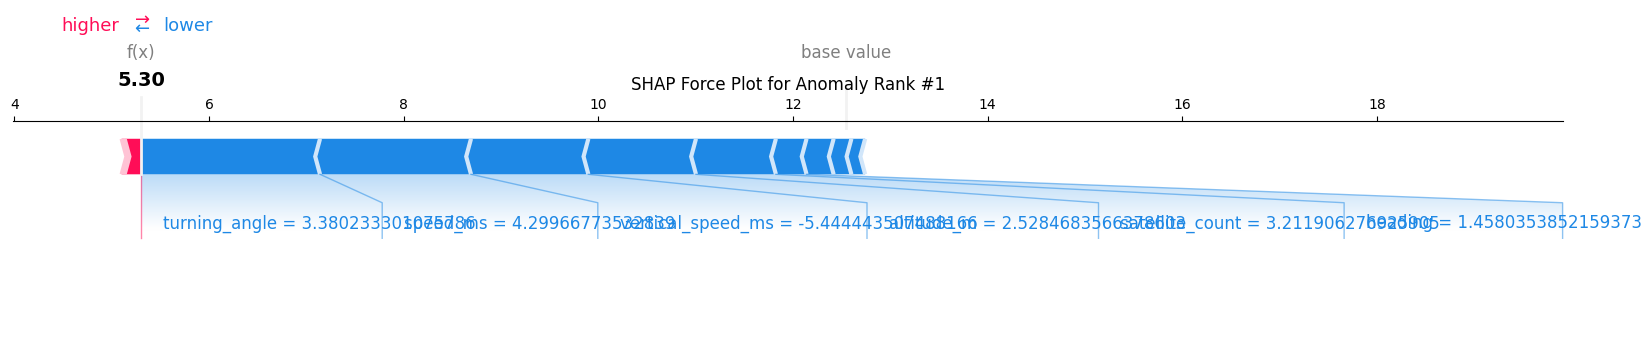

The most impactful feature for this anomaly was 'turning_angle'. Plotting its context.


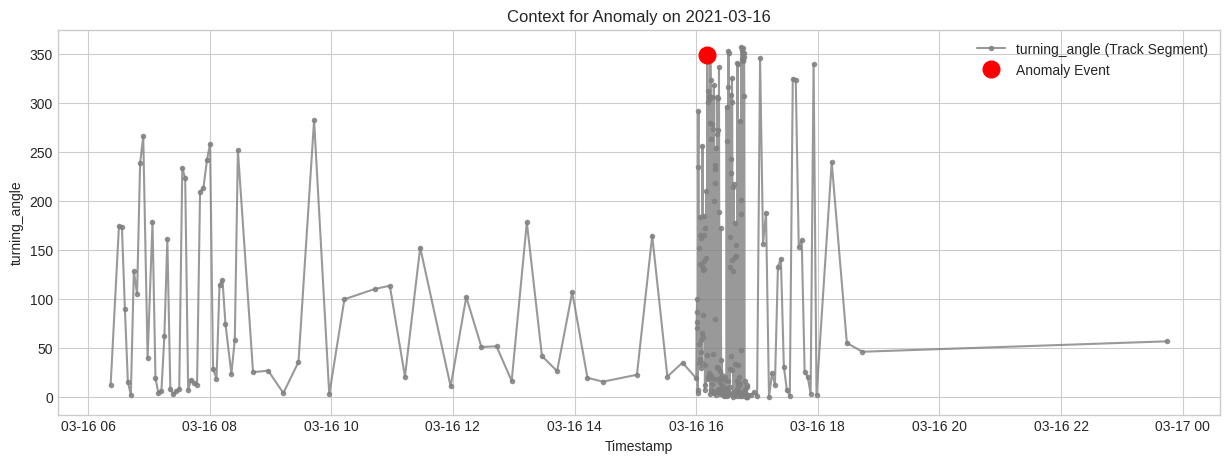

         FULL DOSSIER FOR ANOMALY RANK #2 

Timestamp: 2020-07-21 08:44:15
Animal ID: 2529
Final Ensemble Score: 0.9476

--- Individual Model Contributions (Normalized Scores) ---
IsolationForest    0.982896
SGDOneClassSVM     0.912251
HMM_Likelihood          NaN
Name: 363885, dtype: float64

Primary Model Driver: **IsolationForest**
HMM Behavioral Context: The anomaly occurred during **State 3**.

--- Structural Explanation (from Isolation Forest) ---
The Isolation Forest was a primary driver for this detection.


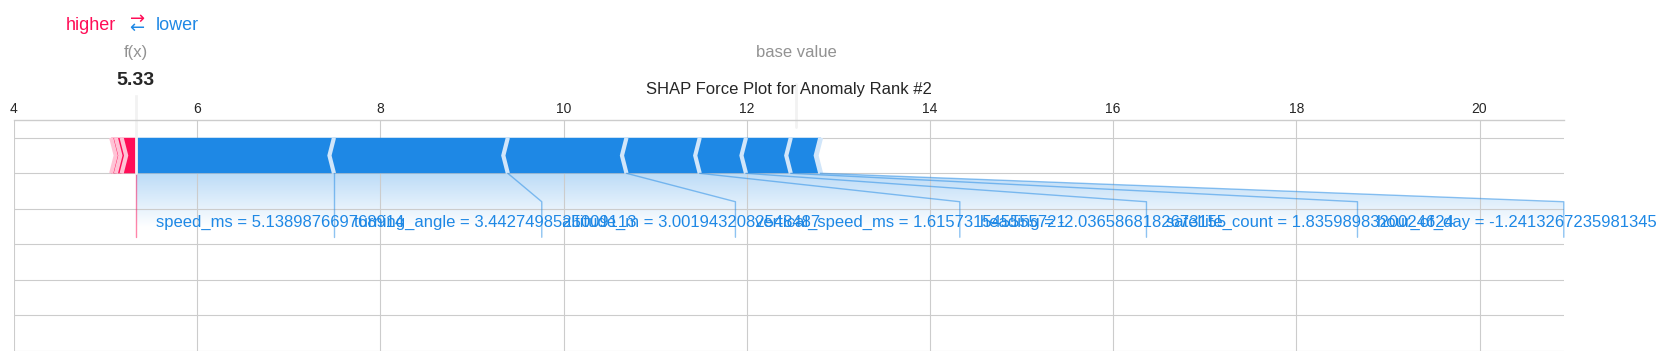

The most impactful feature for this anomaly was 'speed_ms'. Plotting its context.


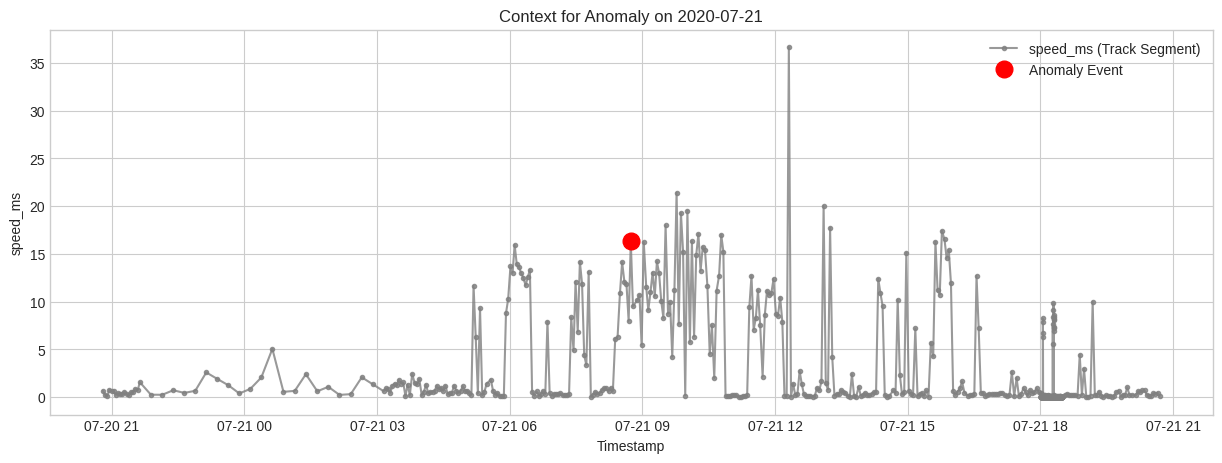

         FULL DOSSIER FOR ANOMALY RANK #3 

Timestamp: 2021-06-07 18:14:52
Animal ID: 2724
Final Ensemble Score: 0.9442

--- Individual Model Contributions (Normalized Scores) ---
IsolationForest    0.985763
SGDOneClassSVM     0.902554
HMM_Likelihood          NaN
Name: 1254914, dtype: float64

Primary Model Driver: **IsolationForest**
HMM Behavioral Context: The anomaly occurred during **State 3**.

--- Structural Explanation (from Isolation Forest) ---
The Isolation Forest was a primary driver for this detection.


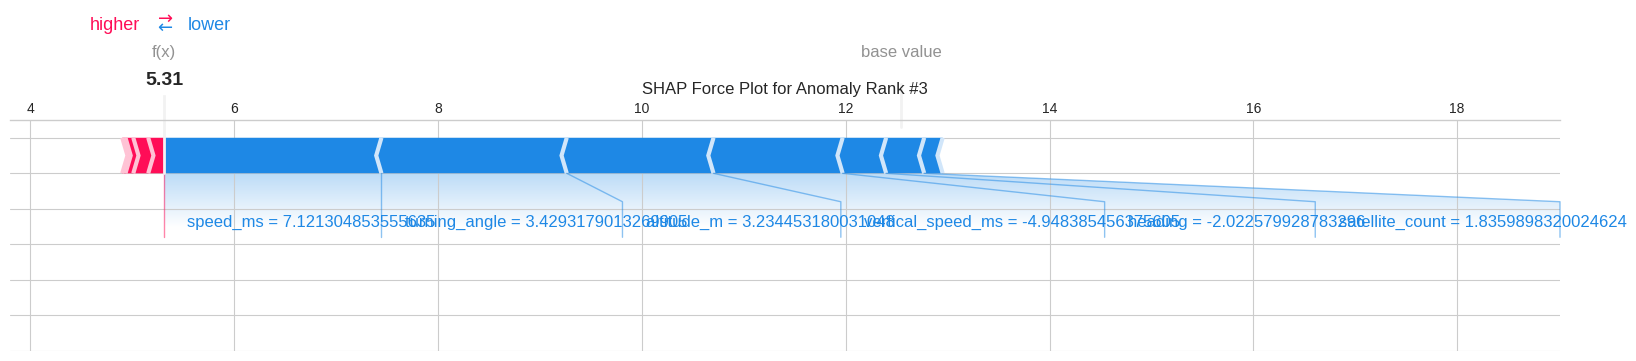

The most impactful feature for this anomaly was 'speed_ms'. Plotting its context.


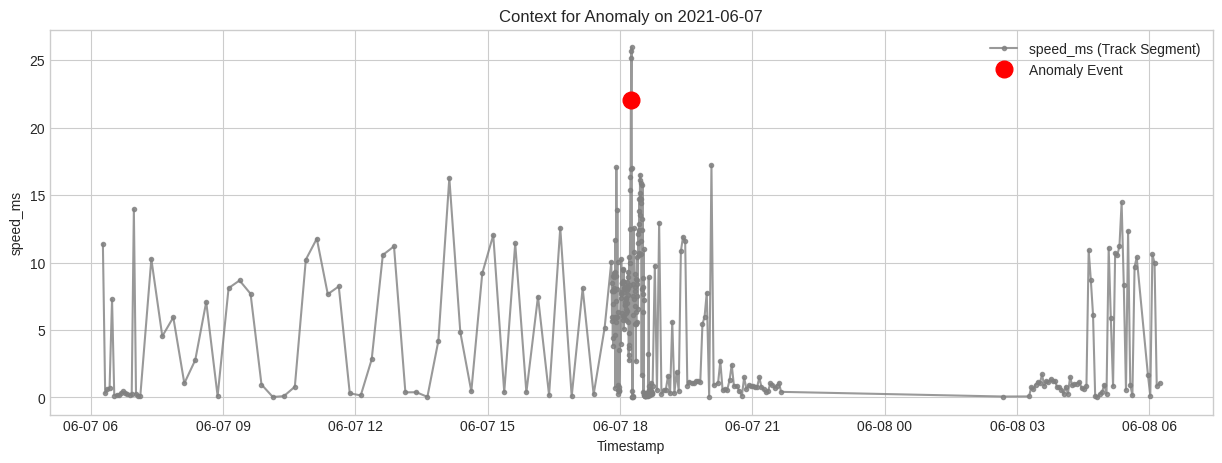

         FULL DOSSIER FOR ANOMALY RANK #4 

Timestamp: 2022-08-02 13:06:58
Animal ID: 2779
Final Ensemble Score: 0.9367

--- Individual Model Contributions (Normalized Scores) ---
IsolationForest    1.000000
SGDOneClassSVM     0.873433
HMM_Likelihood          NaN
Name: 1746652, dtype: float64

Primary Model Driver: **IsolationForest**
HMM Behavioral Context: The anomaly occurred during **State 3**.

--- Structural Explanation (from Isolation Forest) ---
The Isolation Forest was a primary driver for this detection.


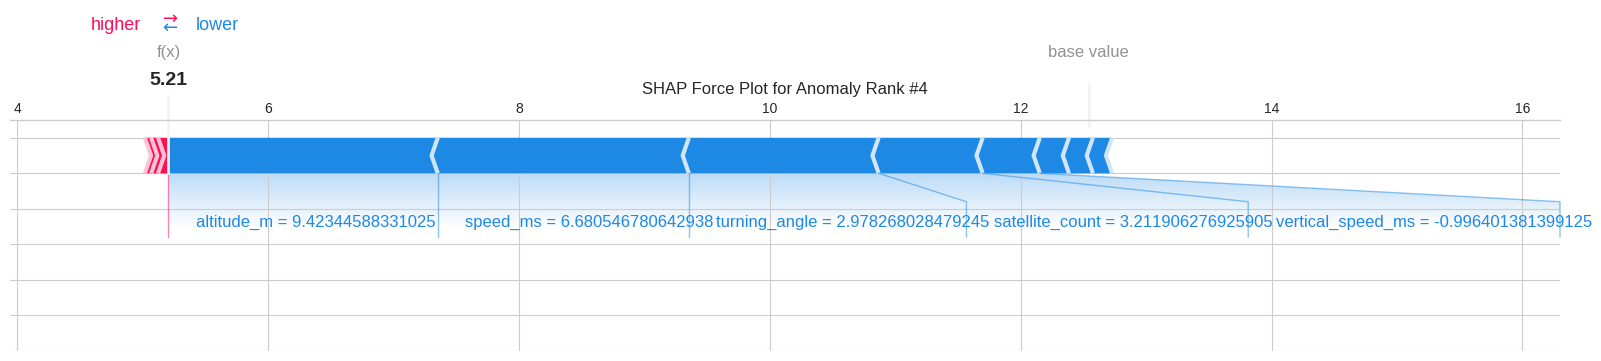

The most impactful feature for this anomaly was 'altitude_m'. Plotting its context.


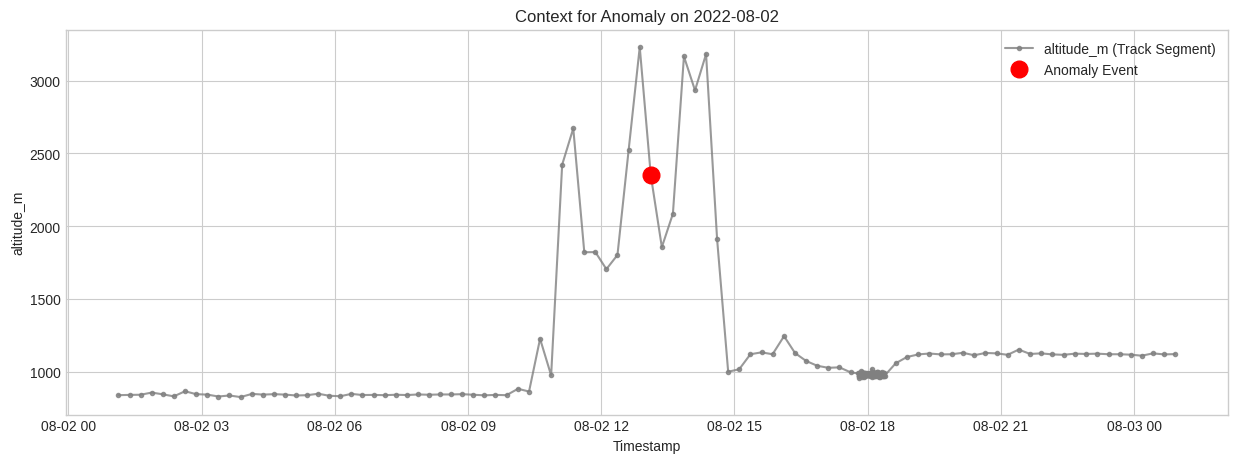

         FULL DOSSIER FOR ANOMALY RANK #5 

Timestamp: 2021-04-30 05:22:22
Animal ID: 2528
Final Ensemble Score: 0.9367

--- Individual Model Contributions (Normalized Scores) ---
IsolationForest    0.980230
SGDOneClassSVM     0.893117
HMM_Likelihood          NaN
Name: 312541, dtype: float64

Primary Model Driver: **IsolationForest**
HMM Behavioral Context: The anomaly occurred during **State 3**.

--- Structural Explanation (from Isolation Forest) ---
The Isolation Forest was a primary driver for this detection.


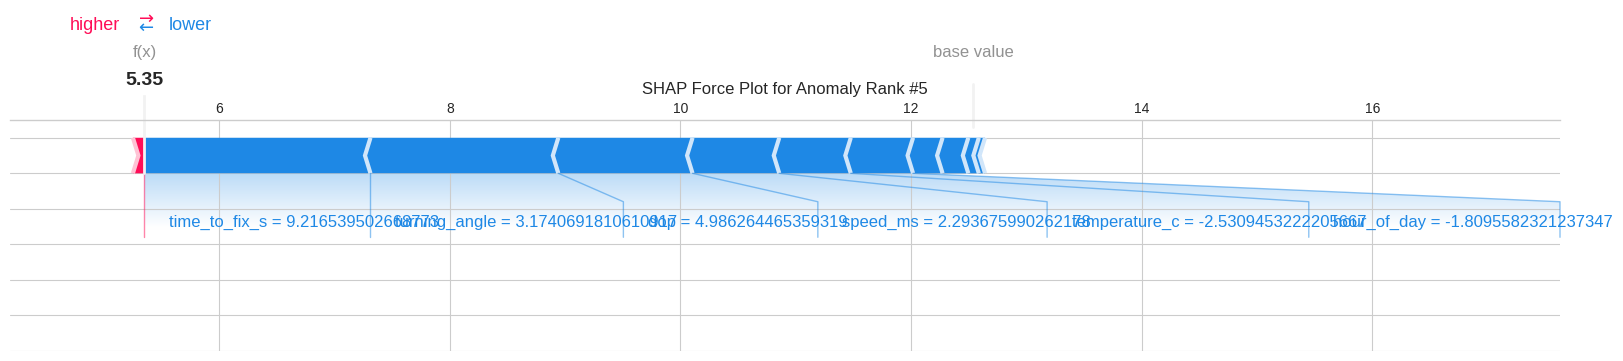

The most impactful feature for this anomaly was 'time_to_fix_s'. Plotting its context.


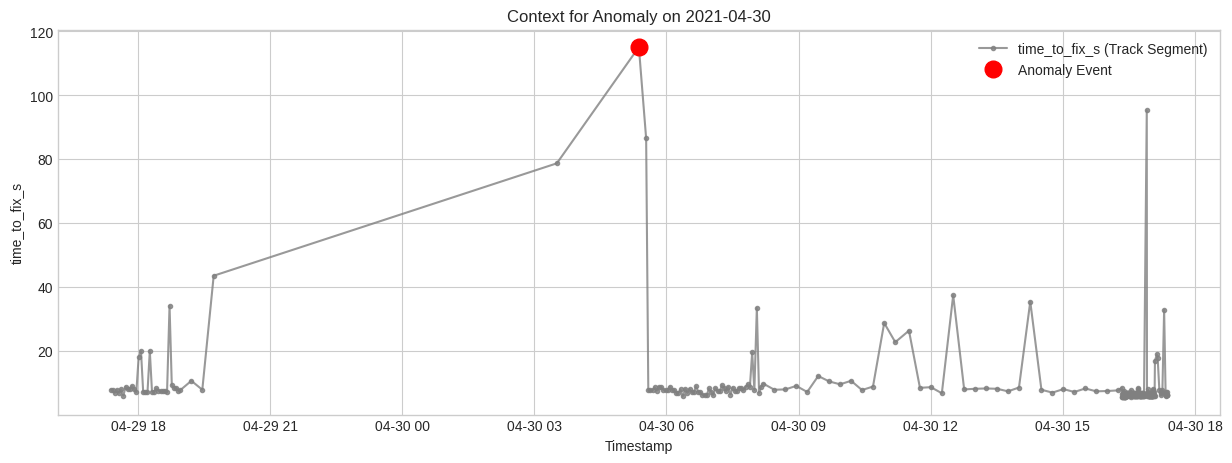

         FULL DOSSIER FOR ANOMALY RANK #6 

Timestamp: 2022-07-13 18:07:26
Animal ID: 2779
Final Ensemble Score: 0.9350

--- Individual Model Contributions (Normalized Scores) ---
IsolationForest    0.979043
SGDOneClassSVM     0.890970
HMM_Likelihood          NaN
Name: 1741916, dtype: float64

Primary Model Driver: **IsolationForest**
HMM Behavioral Context: The anomaly occurred during **State 3**.

--- Structural Explanation (from Isolation Forest) ---
The Isolation Forest was a primary driver for this detection.


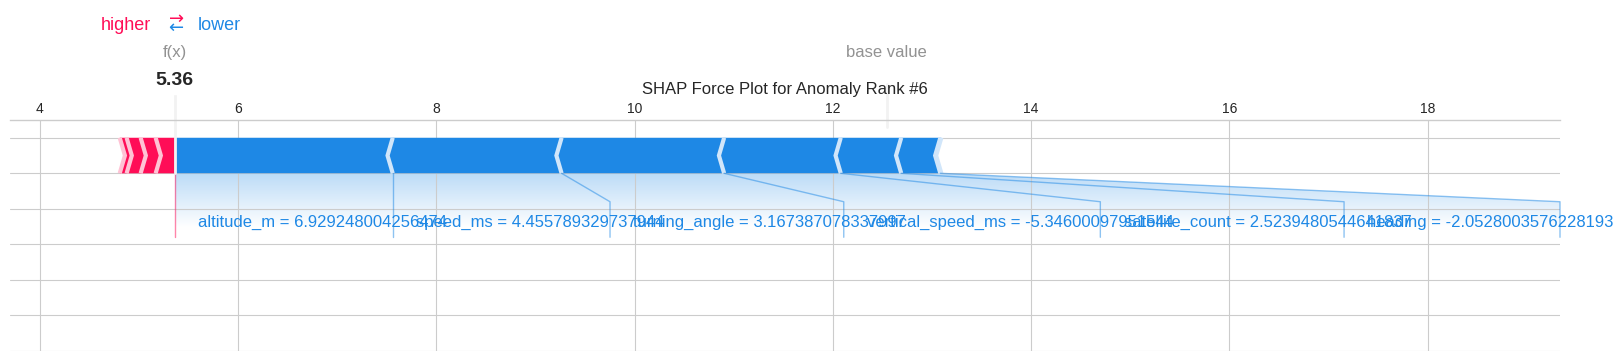

The most impactful feature for this anomaly was 'altitude_m'. Plotting its context.


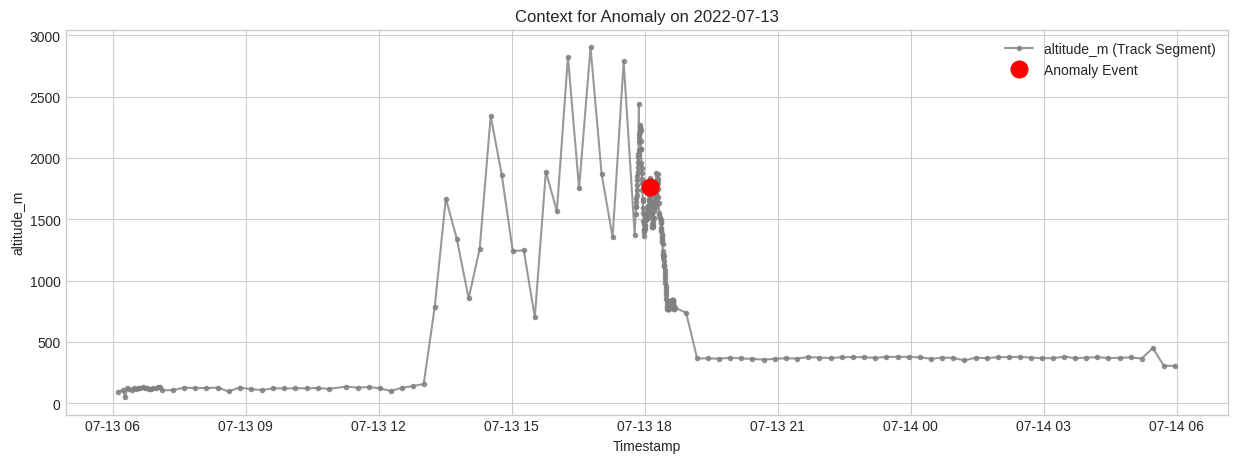

         FULL DOSSIER FOR ANOMALY RANK #7 

Timestamp: 2021-06-07 18:14:36
Animal ID: 2724
Final Ensemble Score: 0.9344

--- Individual Model Contributions (Normalized Scores) ---
IsolationForest    0.968351
SGDOneClassSVM     0.900459
HMM_Likelihood          NaN
Name: 1254913, dtype: float64

Primary Model Driver: **IsolationForest**
HMM Behavioral Context: The anomaly occurred during **State 3**.

--- Structural Explanation (from Isolation Forest) ---
The Isolation Forest was a primary driver for this detection.


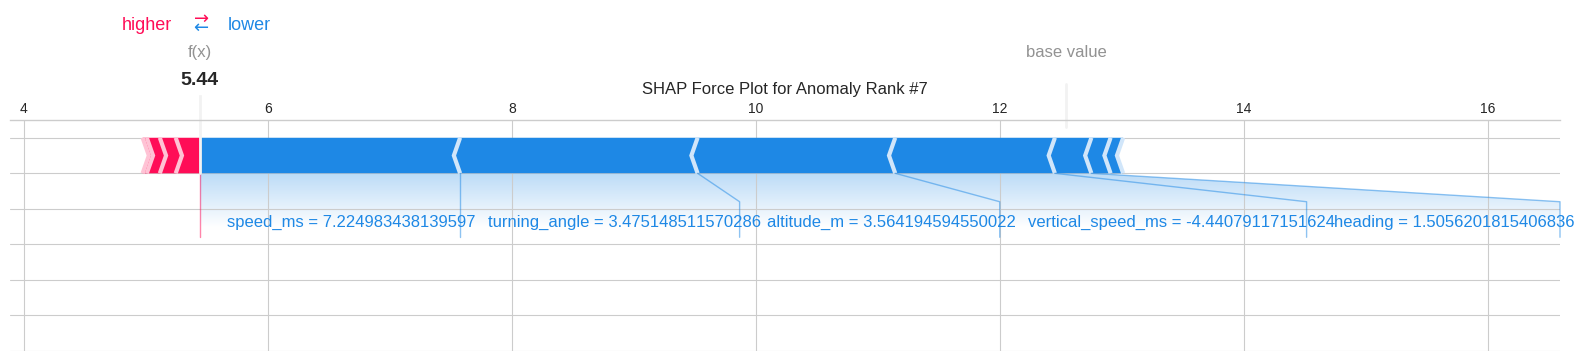

The most impactful feature for this anomaly was 'speed_ms'. Plotting its context.


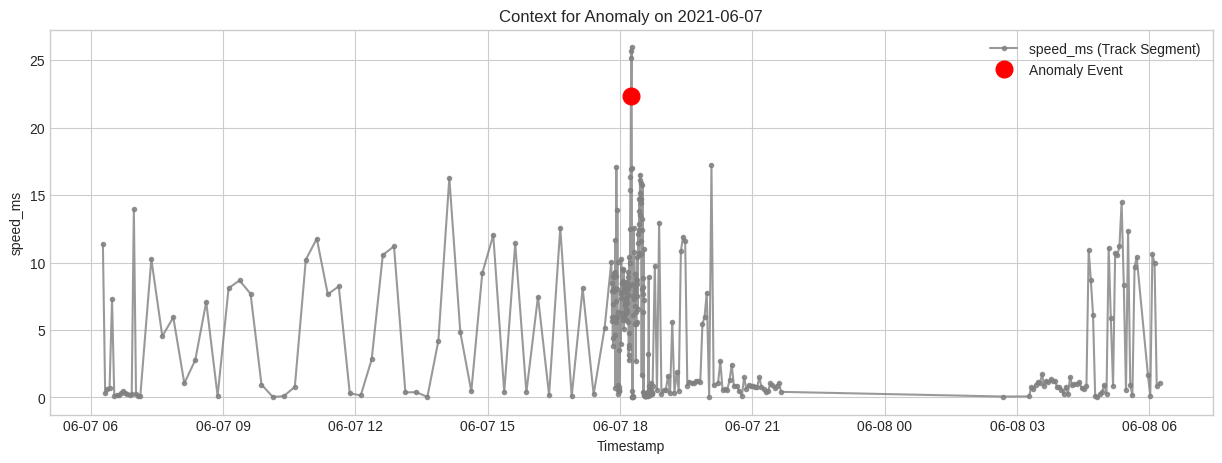

         FULL DOSSIER FOR ANOMALY RANK #8 

Timestamp: 2022-07-24 17:31:57
Animal ID: 2693
Final Ensemble Score: 0.9334

--- Individual Model Contributions (Normalized Scores) ---
IsolationForest    0.954788
SGDOneClassSVM     0.912033
HMM_Likelihood          NaN
Name: 677995, dtype: float64

Primary Model Driver: **IsolationForest**
HMM Behavioral Context: The anomaly occurred during **State 3**.

--- Structural Explanation (from Isolation Forest) ---
The Isolation Forest was a primary driver for this detection.


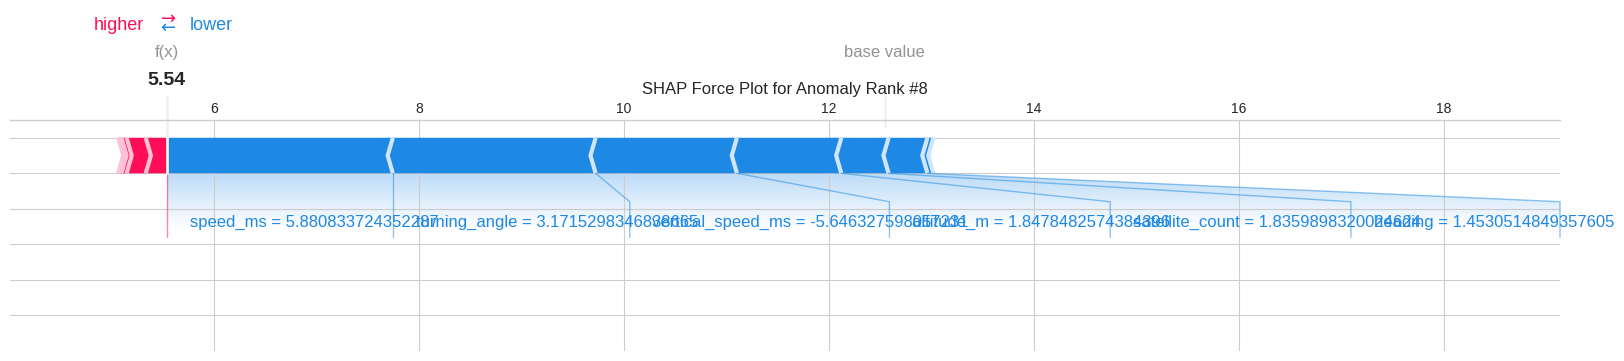

The most impactful feature for this anomaly was 'speed_ms'. Plotting its context.


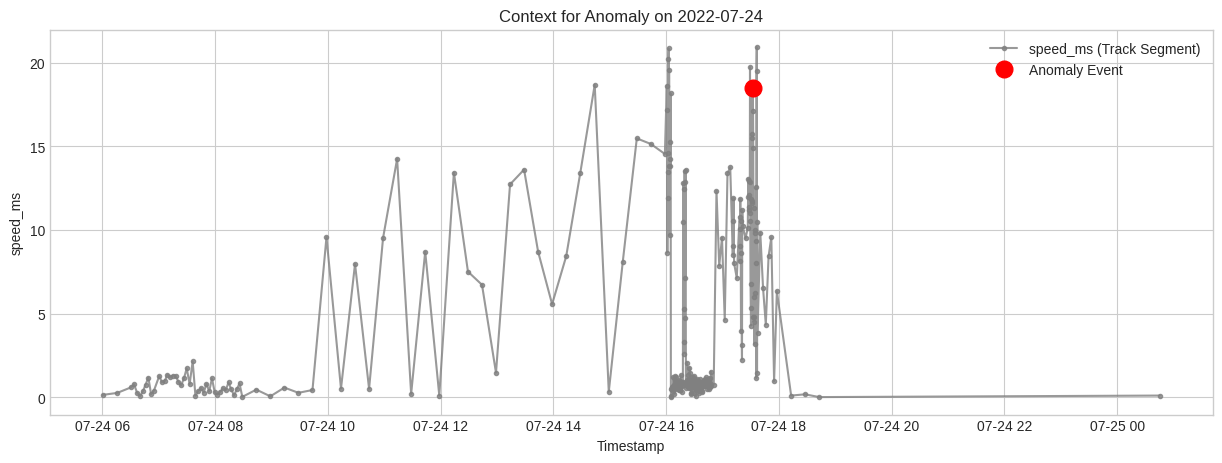

         FULL DOSSIER FOR ANOMALY RANK #9 

Timestamp: 2021-06-07 18:15:24
Animal ID: 2724
Final Ensemble Score: 0.9334

--- Individual Model Contributions (Normalized Scores) ---
IsolationForest    0.966000
SGDOneClassSVM     0.900793
HMM_Likelihood          NaN
Name: 1254916, dtype: float64

Primary Model Driver: **IsolationForest**
HMM Behavioral Context: The anomaly occurred during **State 3**.

--- Structural Explanation (from Isolation Forest) ---
The Isolation Forest was a primary driver for this detection.


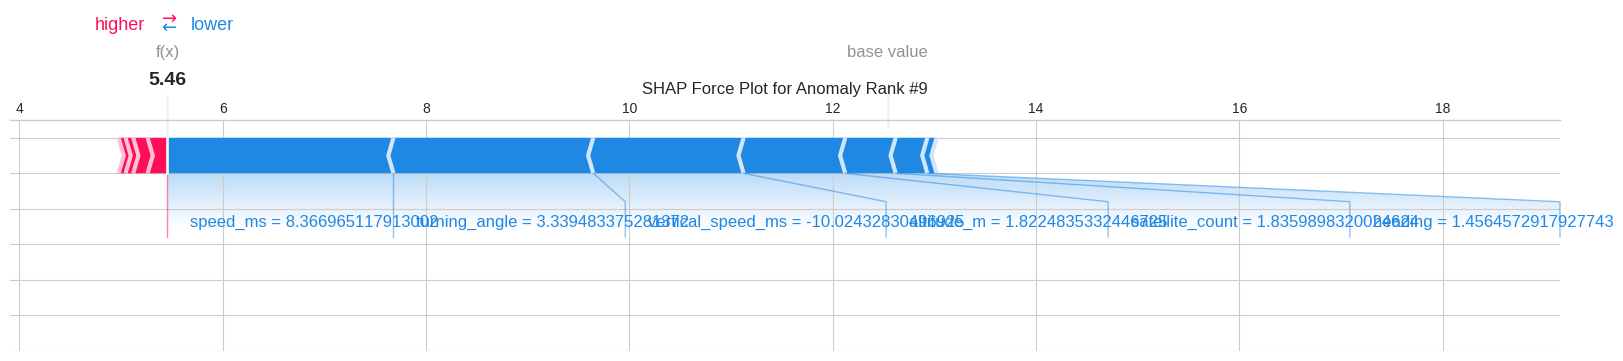

The most impactful feature for this anomaly was 'speed_ms'. Plotting its context.


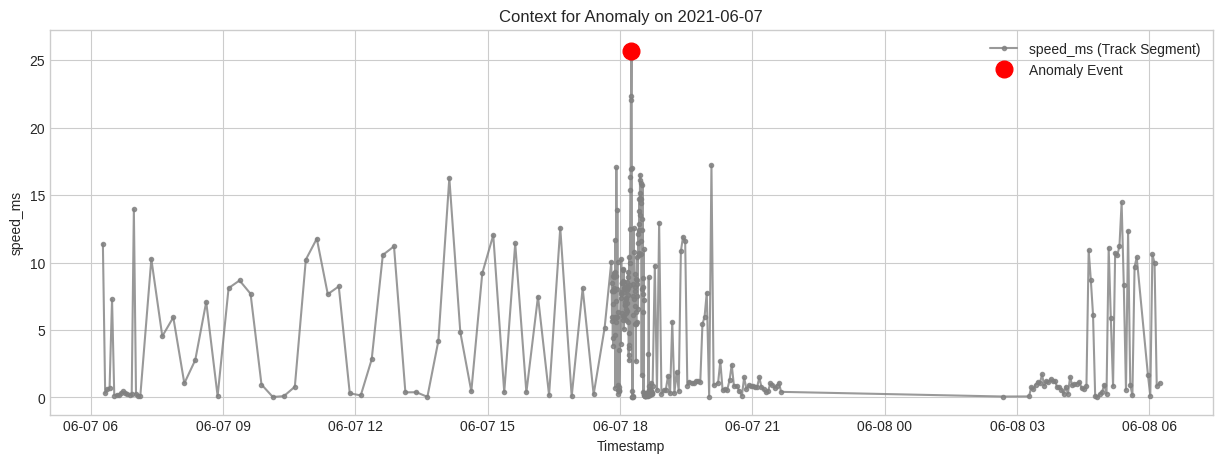

         FULL DOSSIER FOR ANOMALY RANK #10 

Timestamp: 2023-06-27 11:43:29
Animal ID: 2718
Final Ensemble Score: 0.9287

--- Individual Model Contributions (Normalized Scores) ---
IsolationForest    0.954514
SGDOneClassSVM     0.902826
HMM_Likelihood          NaN
Name: 1056987, dtype: float64

Primary Model Driver: **IsolationForest**
HMM Behavioral Context: The anomaly occurred during **State 3**.

--- Structural Explanation (from Isolation Forest) ---
The Isolation Forest was a primary driver for this detection.


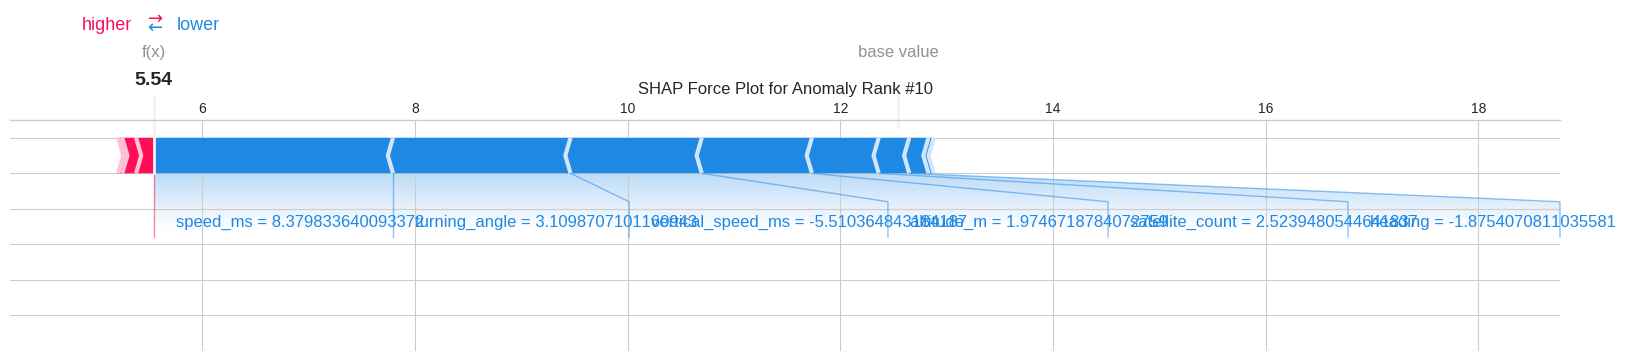

The most impactful feature for this anomaly was 'speed_ms'. Plotting its context.


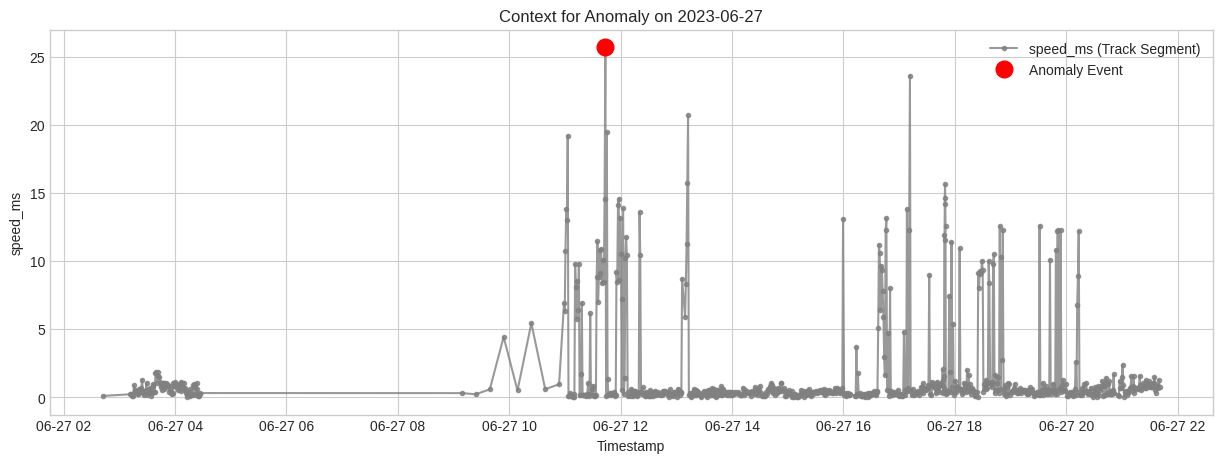

         FULL DOSSIER FOR ANOMALY RANK #11 

Timestamp: 2022-07-13 18:39:10
Animal ID: 2779
Final Ensemble Score: 0.9276

--- Individual Model Contributions (Normalized Scores) ---
IsolationForest    0.943444
SGDOneClassSVM     0.911657
HMM_Likelihood          NaN
Name: 1742030, dtype: float64

Primary Model Driver: **IsolationForest**
HMM Behavioral Context: The anomaly occurred during **State 3**.

--- Structural Explanation (from Isolation Forest) ---
The Isolation Forest was a primary driver for this detection.


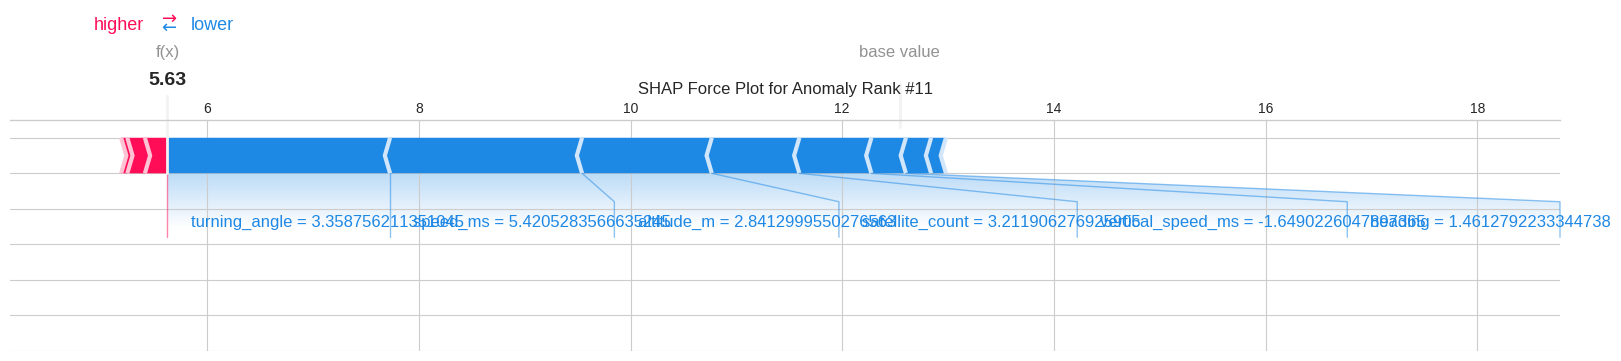

The most impactful feature for this anomaly was 'turning_angle'. Plotting its context.


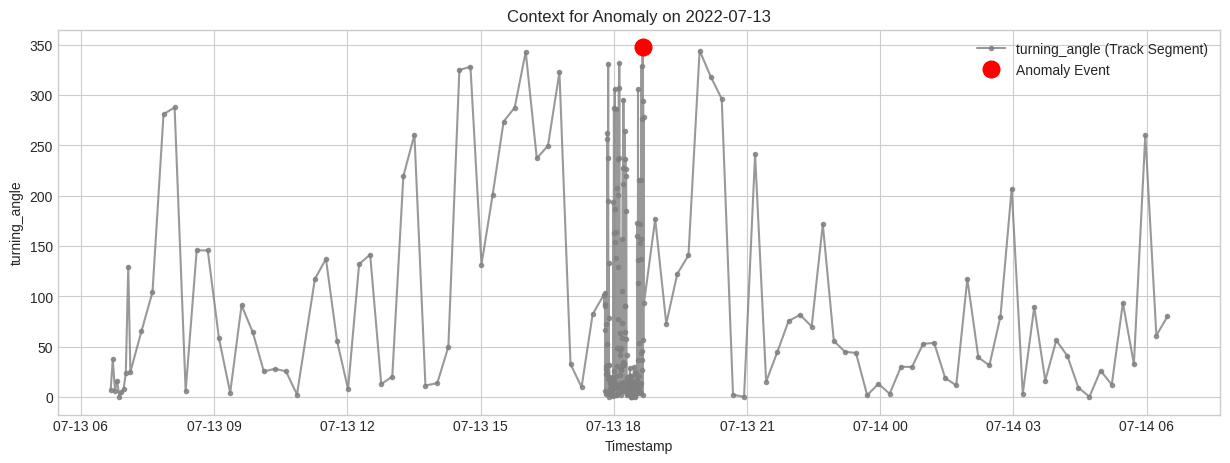

         FULL DOSSIER FOR ANOMALY RANK #12 

Timestamp: 2020-09-15 12:05:55
Animal ID: 2529
Final Ensemble Score: 0.9274

--- Individual Model Contributions (Normalized Scores) ---
IsolationForest    0.957954
SGDOneClassSVM     0.896788
HMM_Likelihood          NaN
Name: 405368, dtype: float64

Primary Model Driver: **IsolationForest**
HMM Behavioral Context: The anomaly occurred during **State 3**.

--- Structural Explanation (from Isolation Forest) ---
The Isolation Forest was a primary driver for this detection.


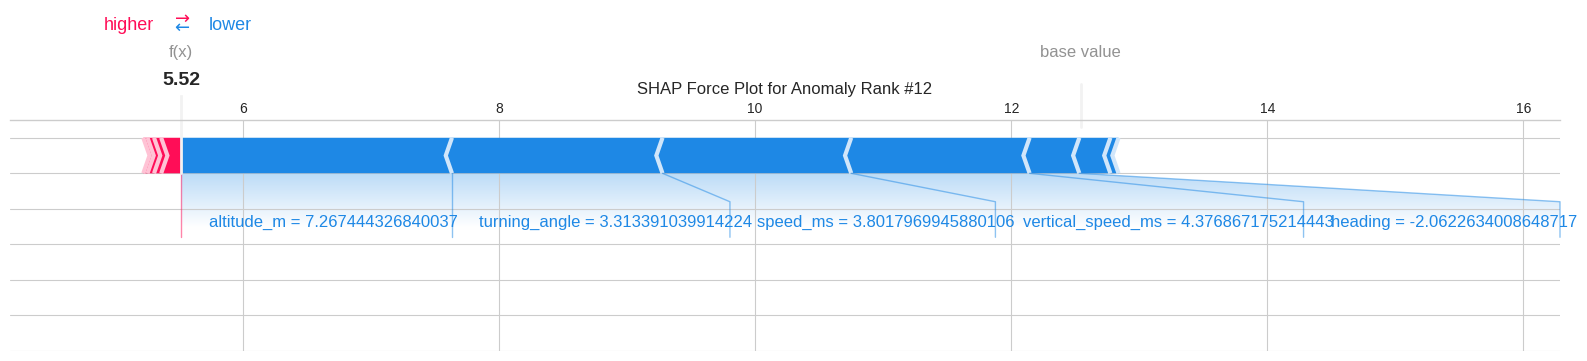

The most impactful feature for this anomaly was 'altitude_m'. Plotting its context.


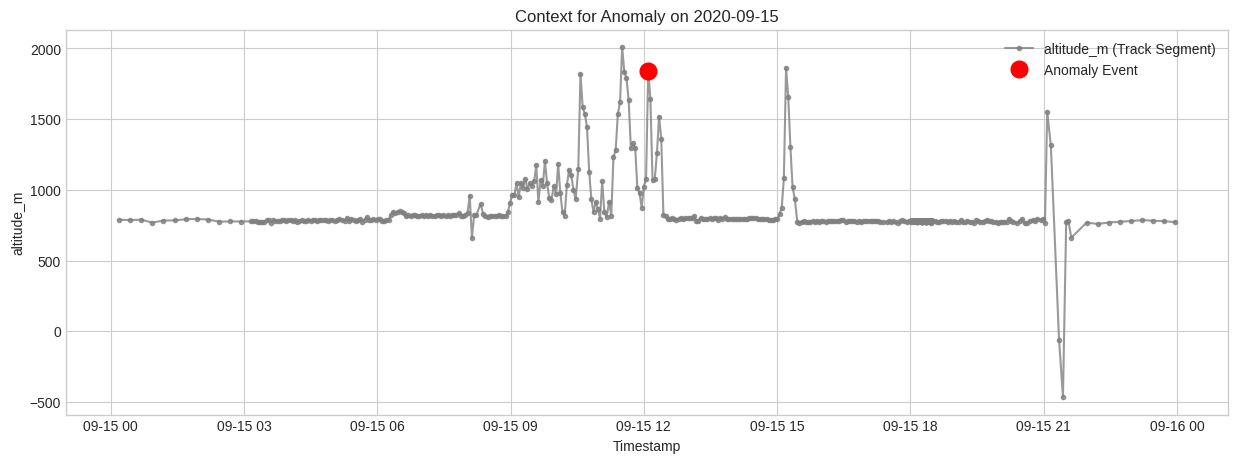

         FULL DOSSIER FOR ANOMALY RANK #13 

Timestamp: 2022-07-13 18:38:54
Animal ID: 2779
Final Ensemble Score: 0.9265

--- Individual Model Contributions (Normalized Scores) ---
IsolationForest    0.941192
SGDOneClassSVM     0.911806
HMM_Likelihood          NaN
Name: 1742029, dtype: float64

Primary Model Driver: **IsolationForest**
HMM Behavioral Context: The anomaly occurred during **State 3**.

--- Structural Explanation (from Isolation Forest) ---
The Isolation Forest was a primary driver for this detection.


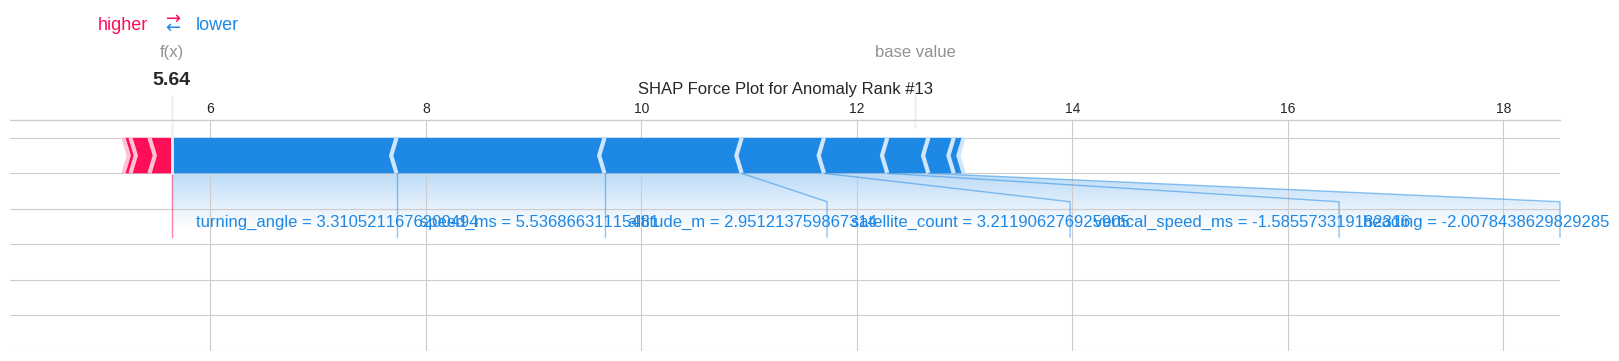

The most impactful feature for this anomaly was 'turning_angle'. Plotting its context.


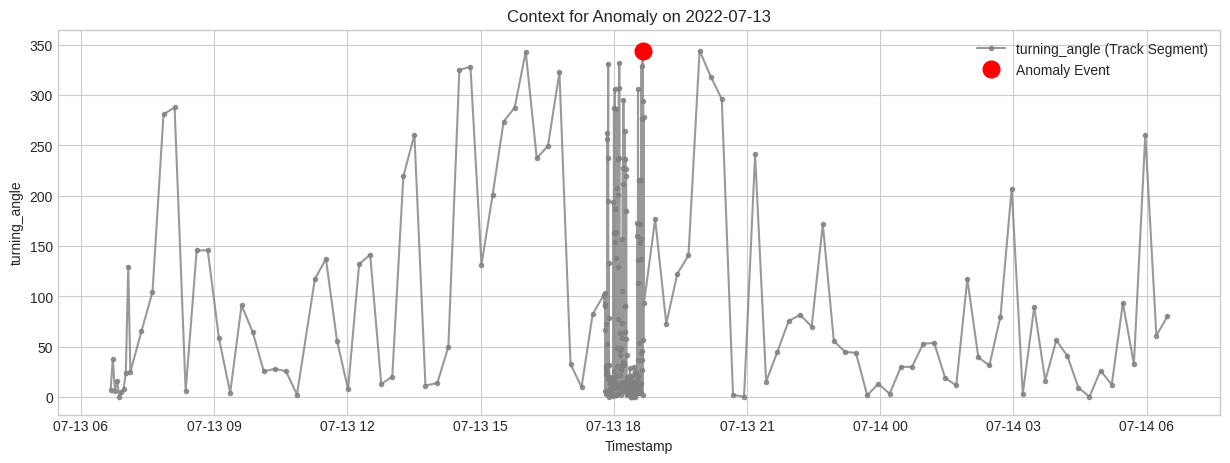

         FULL DOSSIER FOR ANOMALY RANK #14 

Timestamp: 2023-07-03 09:34:19
Animal ID: 2718
Final Ensemble Score: 0.9237

--- Individual Model Contributions (Normalized Scores) ---
SGDOneClassSVM     0.923796
IsolationForest    0.923521
HMM_Likelihood          NaN
Name: 1061415, dtype: float64

Primary Model Driver: **SGDOneClassSVM**
HMM Behavioral Context: The anomaly occurred during **State 3**.

--- Structural Explanation (from Isolation Forest) ---
Note: While the SVM flagged this as outside the 'normal' boundary,
we use the Isolation Forest explanation to understand the structural features.


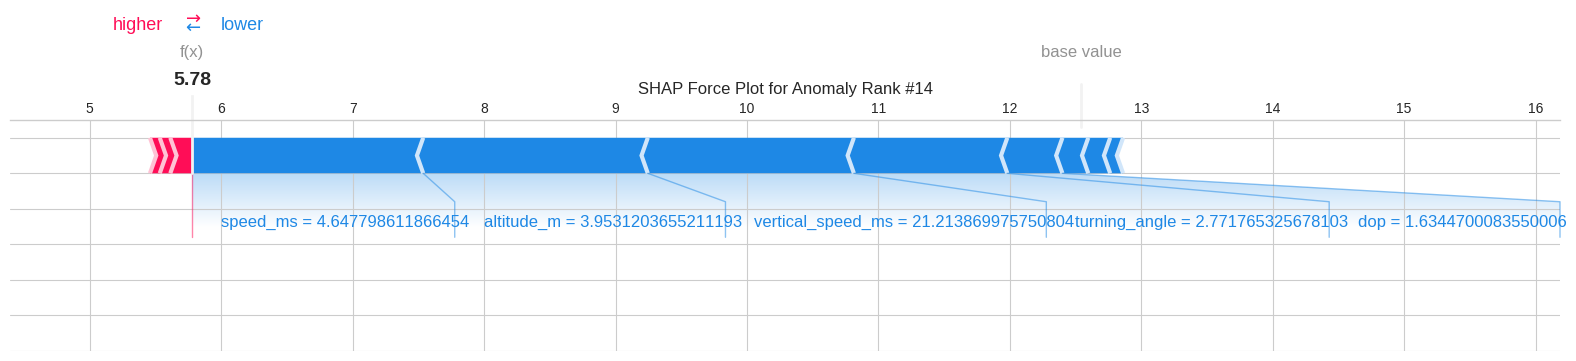

The most impactful feature for this anomaly was 'speed_ms'. Plotting its context.


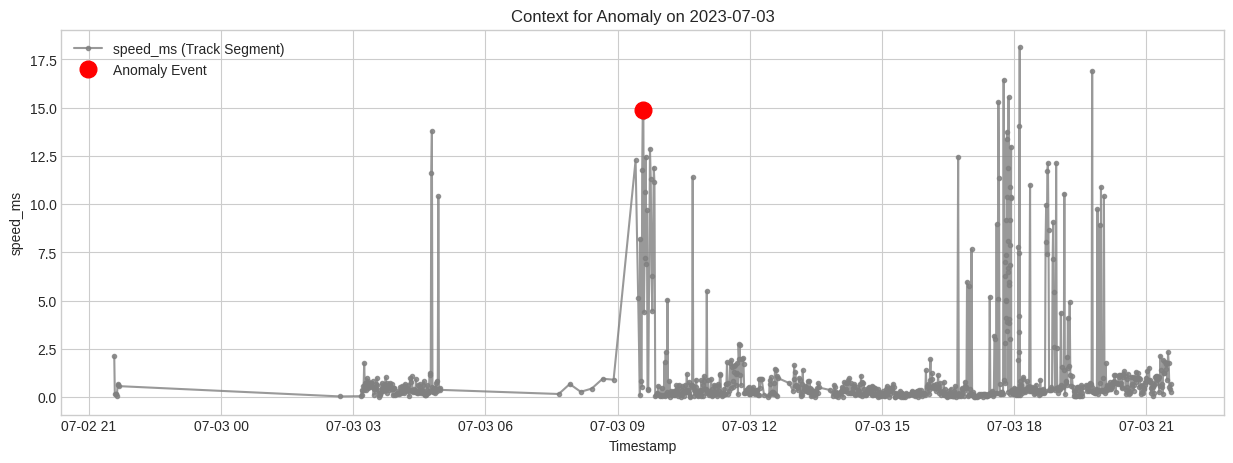

         FULL DOSSIER FOR ANOMALY RANK #15 

Timestamp: 2022-08-21 22:17:45
Animal ID: 2779
Final Ensemble Score: 0.9236

--- Individual Model Contributions (Normalized Scores) ---
IsolationForest    0.969862
SGDOneClassSVM     0.877392
HMM_Likelihood          NaN
Name: 1747793, dtype: float64

Primary Model Driver: **IsolationForest**
HMM Behavioral Context: The anomaly occurred during **State 3**.

--- Structural Explanation (from Isolation Forest) ---
The Isolation Forest was a primary driver for this detection.


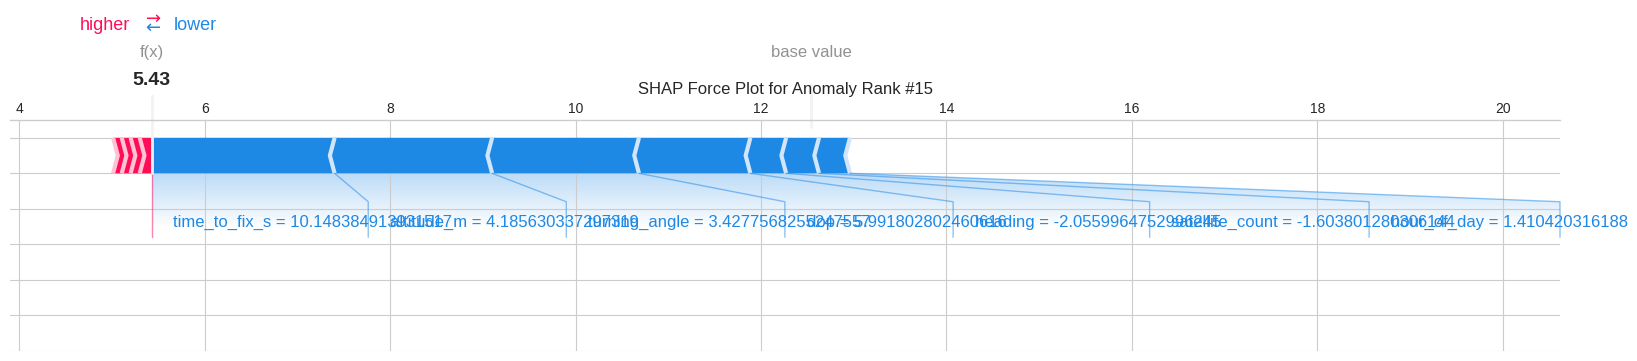

The most impactful feature for this anomaly was 'time_to_fix_s'. Plotting its context.


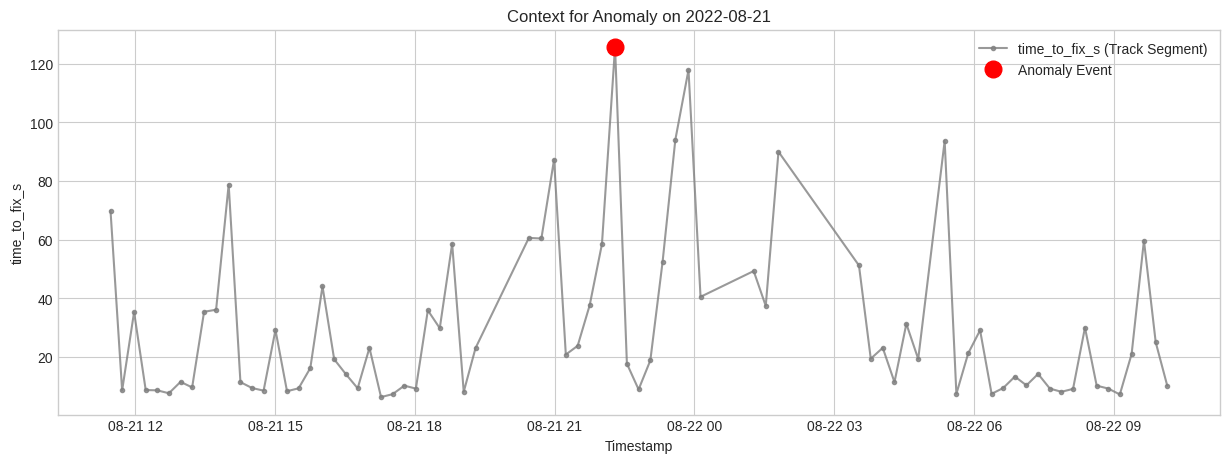

In [28]:
# Cell 8.1

N_FINAL_REVIEW = 15

print("="*80)
print("         FINAL ANALYSIS & INTERPRETATION OF REAL ANOMALIES         ")
print("="*80)

# Loop through the top anomalies and generate the full dossier for each one
for rank in range(1, N_FINAL_REVIEW + 1):
    # This call now uses our new, smarter reporting function
    generate_full_anomaly_report(
        anomaly_rank=rank,
        # We pass the normalized scores from the original run
        anomaly_scores_df=(
            anomaly_scores.pipe(lambda df: (df - df.min()) / (df.max() - df.min()))
        )
    )